   • Below are the sample solutions for all the questions.<br>
   • You may compare the work which you have accomplished with the sample solution provided to share your observations with          us or make changes to your craft.<br>
   • The summary statistics are spread across different questions. You may calculate the summary statistics for every question, as suggested in the assignment question.

In [1]:
# Install it again from its github repo
#!pip install git+https://github.com/quantopian/pyfolio

## Problem I - Backtests a strategy using three moving averages on any indices such as Nifty50, SPY, HSI and so on.

- Compute three moving averages of 20, 40, and 80.
- Go long when the price crosses above all three moving averages.
- Exit the long position when the price crosses below any of the three moving averages.
- Go short when the price crosses below all three moving averages.
- Exit the short position when the price crosses above any of the three moving averages.
- Optional: Optimize all three moving averages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
def download_data(stock, start, end):
    data = yf.download(stock, start, end, group_by = "ticker")[stock]
    data.index = pd.to_datetime(data.index)
    return data

In [5]:
def generate_returns(stock):
    data['p_returns'] = data['Close'].pct_change()
    return data

In [7]:
def backtest_strategy(df, sma, mma, lma, print_chart):
    # Copy the data
    data = df.copy()
    
    # Create the moving averages
    data['sma'] = data['Close'].rolling(window=sma).mean()
    data['mma'] = data['Close'].rolling(window=mma).mean()
    data['lma'] = data['Close'].rolling(window=lma).mean()
    
    # Create the signal column
    data['signal'] = np.nan
    
    # Set the length of the dataframe
    n = data.shape[0]
    
    # Loop through each day to compute the signal
    for i in range(1, n): 
        
        # Set the first day signal to zero
        if i == 1:
            data['signal'].iloc[i-1] = 0.0
            
        # Check if the three moving averages have non-Nan values
        if data[['sma','mma','lma']].iloc[i].isnull().values.any():
            data['signal'].iloc[i] = 0.0
            continue
        
        # Set the conditions per each moving average
        cond_sma = data['Close'].iloc[i] >= data['sma'].iloc[i]
        cond_mma = data['Close'].iloc[i] >= data['mma'].iloc[i]
        cond_lma = data['Close'].iloc[i] >= data['lma'].iloc[i]

        # Check if we have no position in the asset
        if (data['signal'].iloc[i-1] == np.nan) | (data['signal'].iloc[i-1] == 0.0):
            # Check if we need to go long for today
            if cond_sma & cond_mma & cond_lma:
                data['signal'].iloc[i] = 1.0
            # Check if we need to go short for today
            elif (cond_sma==False) & (cond_mma==False) & (cond_lma==False):
                data['signal'].iloc[i] = -1.0
            else:
                data['signal'].iloc[i] = 0.0
        # Check if we are long for today
        elif data['signal'].iloc[i-1] == 1.0:
            # Check if we need to close our long position
            if (cond_sma==False) | (cond_mma==False) | (cond_lma==False):
                data['signal'].iloc[i] = 0.0
            # Carry the long position for the next day
            else:
                data['signal'].iloc[i] = 1.0
        # Check if we are short for today
        elif data['signal'].iloc[i-1] == -1.0:
            # Check if we need to close our short position
            if cond_sma | cond_mma | cond_lma:
                data['signal'].iloc[i] = 0.0
            # Carry the short position for the next day
            else:
                data['signal'].iloc[i] = -1.0

    # Print in case it's needed
    if print_chart == True:
        data[['signal', 'sma', 'mma', 'lma', 'Close']].iloc[50:130].plot(
            figsize=(10, 6), secondary_y='signal')

    # Compute the strategy returns
    data['strategy_returns'] = data['p_returns'] * data['signal'].shift(1)

    return data

In [9]:
def calculate_returns(data):
    bnh = (data['p_returns']+1).cumprod()[-1]
    s_returns = (data['strategy_returns']+1).cumprod()[-1]

    return bnh, s_returns

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Buy and hold returns: 3.11
Strategy returns: 3.05


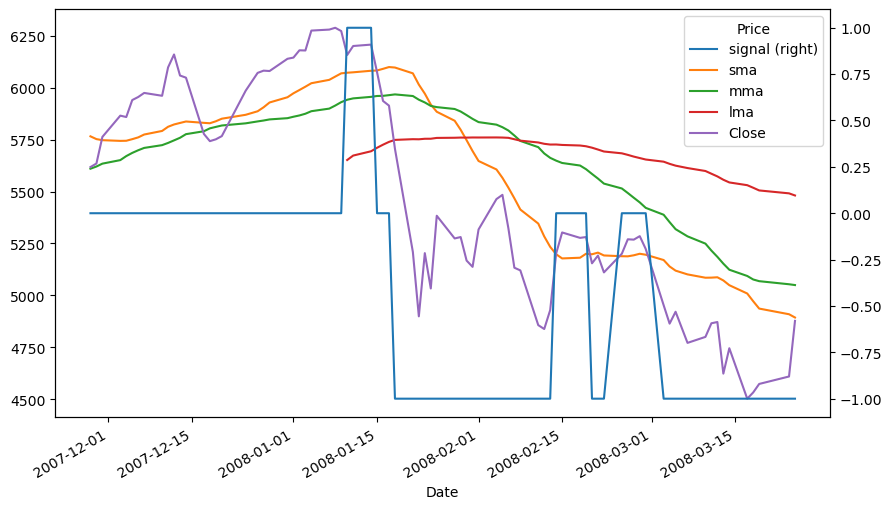

In [11]:
data = download_data('^NSEI', '2001-1-01', '2020-12-31')
data = generate_returns(data)
data = backtest_strategy(data, 20, 40, 80, True)

bnh, s_returns = calculate_returns(data)

print('Buy and hold returns:', np.round(bnh, 2))
print('Strategy returns:', np.round(s_returns, 2))

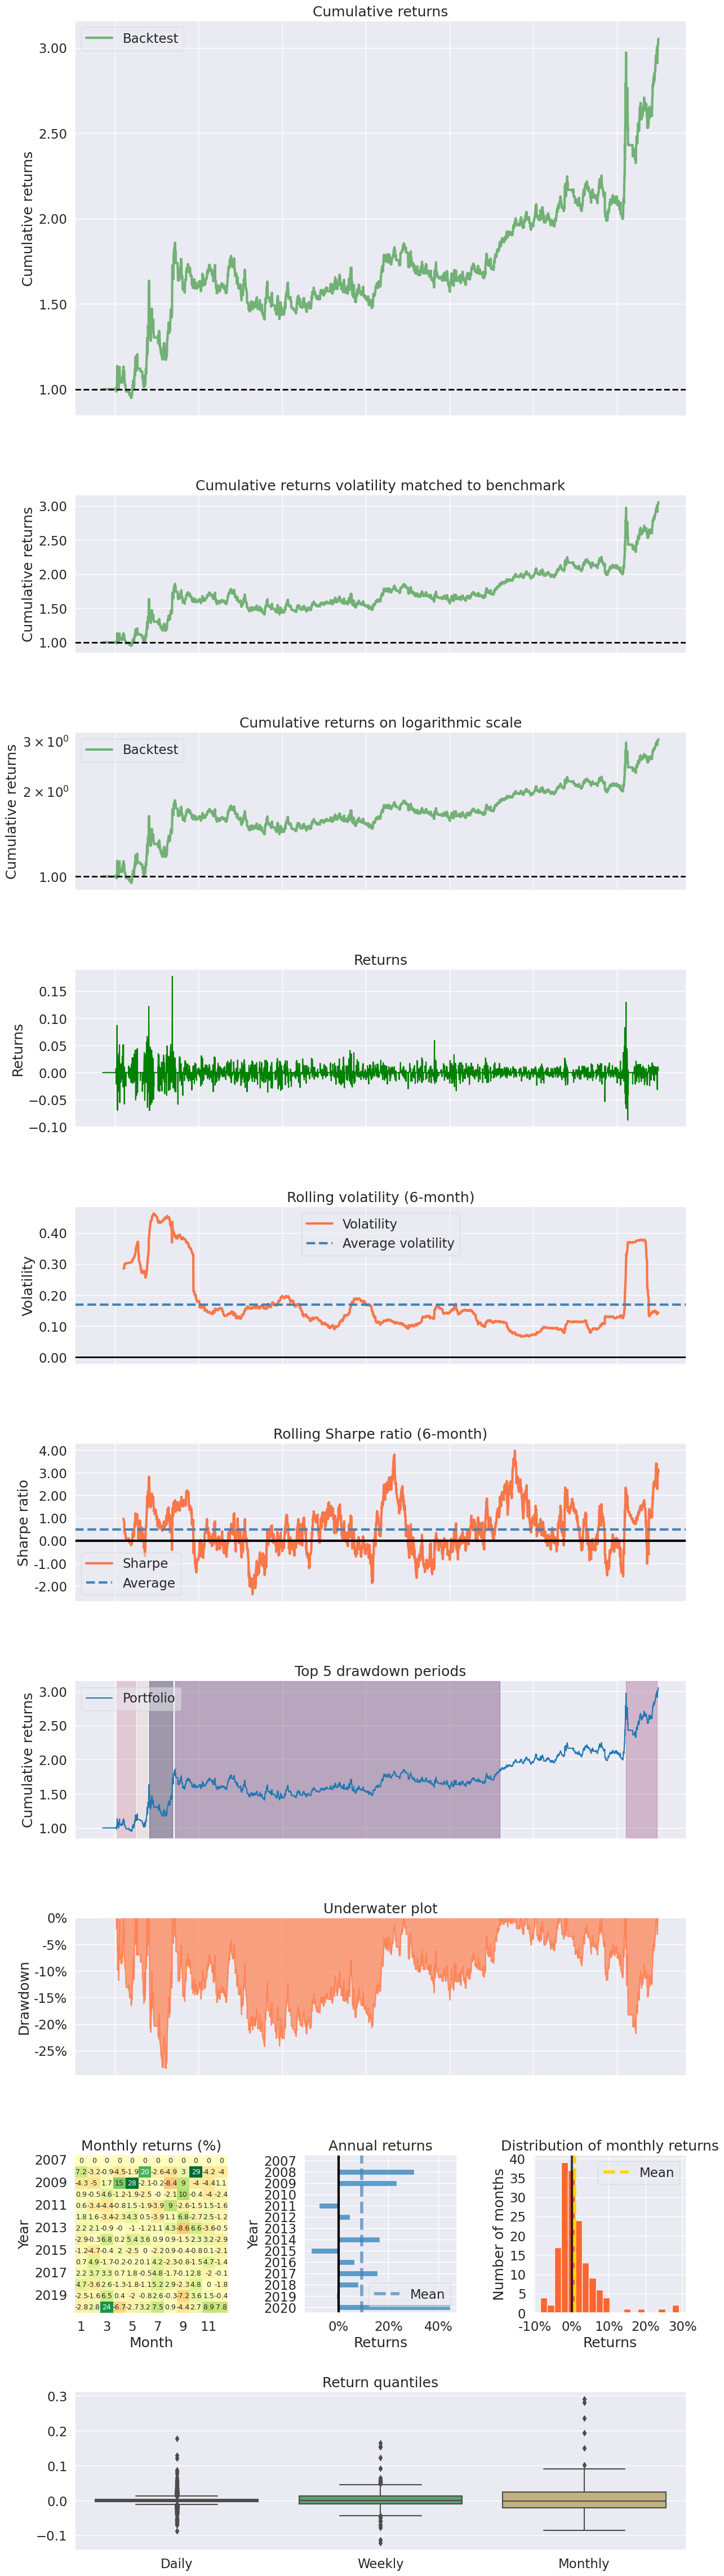

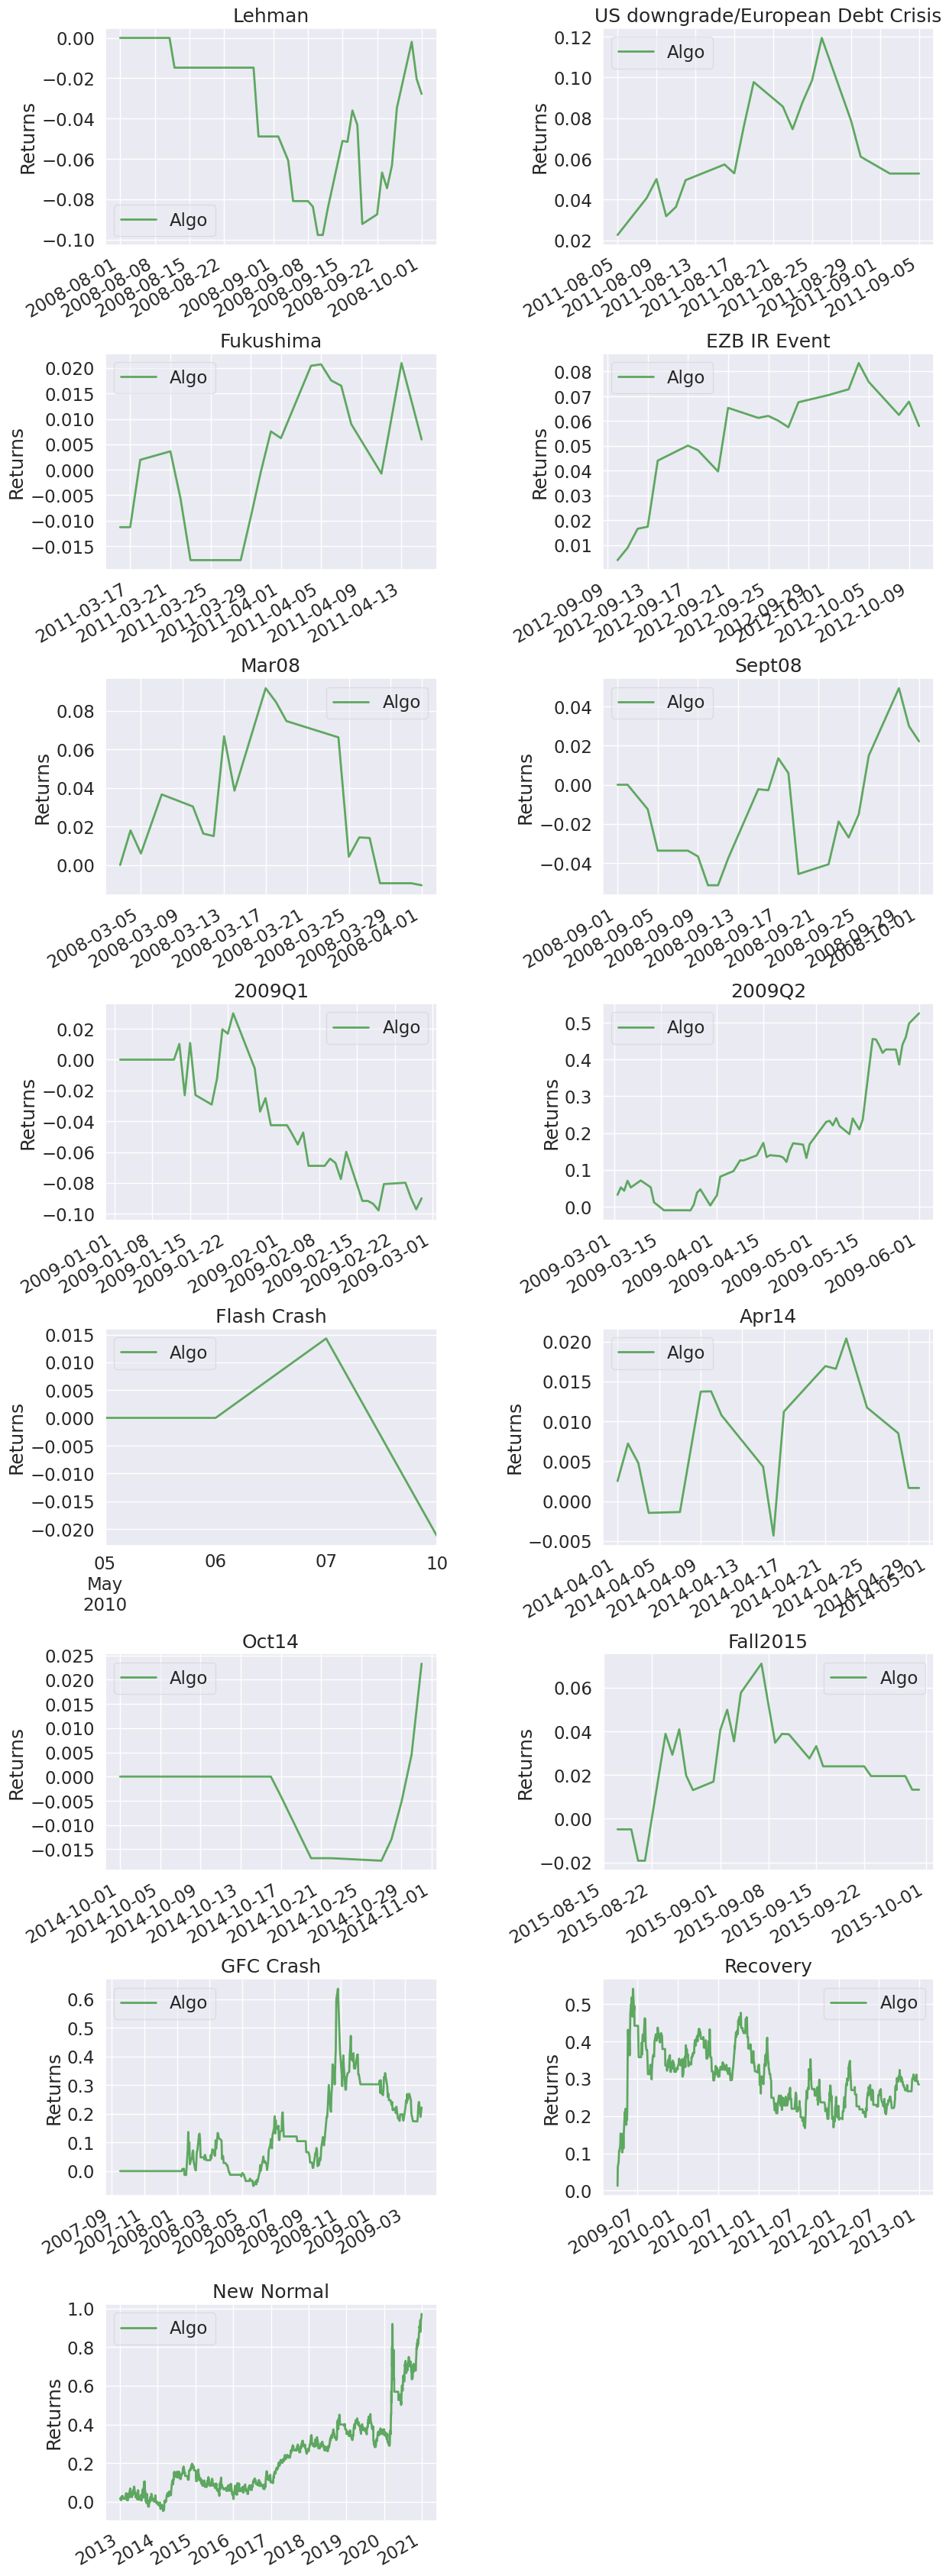

In [8]:
# Get the summary statistics for the strategy using pyfolio
import pyfolio as pf

pf.create_full_tear_sheet(data['strategy_returns'])

In [9]:
data = download_data('^NSEI', '2015-1-1', '2020-12-31')
ma_dict = {}

# Optimize the strategy
for sma in range(30, 40, 5):
    for mma in range(60, 75, 5):
        for lma in range(100, 115, 5):
            key = 'sma'+str(sma)+'_mma'+str(mma)+'_lma'+str(lma)
            print(f'\nChecking for SMA: {sma}, MMA: {mma}, LMA: {lma}')
            df = data.copy()
            df = data = generate_returns(df)
            df = backtest_strategy(df, sma, mma, lma, False)
            bnh, s_returns = calculate_returns(df)
            print('Buy and hold returns:', np.round(bnh, 2))
            print('Strategy returns:', np.round(s_returns, 2))
            ma_dict[key] = s_returns
else:
    print('Computation Completed.')

# Print the sma, mma, lma values that yield the max strategy returns
max_ret = max(ma_dict.values())
opt_values = [key for key, value in ma_dict.items() if value == max_ret]
print(f"The max strategy returns are {max_ret} for the values {opt_values}.")

[*********************100%***********************]  1 of 1 completed

Checking for SMA: 30, MMA: 60, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.66

Checking for SMA: 30, MMA: 60, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.63

Checking for SMA: 30, MMA: 60, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.64

Checking for SMA: 30, MMA: 65, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.66

Checking for SMA: 30, MMA: 65, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.63

Checking for SMA: 30, MMA: 65, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.64

Checking for SMA: 30, MMA: 70, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.65

Checking for SMA: 30, MMA: 70, LMA: 105
Buy and hold returns: 1.67
Strategy returns: 1.62

Checking for SMA: 30, MMA: 70, LMA: 110
Buy and hold returns: 1.67
Strategy returns: 1.63

Checking for SMA: 35, MMA: 60, LMA: 100
Buy and hold returns: 1.67
Strategy returns: 1.78

Checking for SMA: 35

## Problem II - Buy and sell the next day
- Buy the stock on the fourth day open, if the stock closes down consecutively for three days.
- Exit on the next day open.
- Optional: Optimize the strategy by exiting the long position on the same day close.

Also, you can optimize the number of down days. There are high chances that the number of down days would be different for each stock.

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
df = yf.download('TSLA', start='2010-1-1', end='2020-03-31', group_by = 'ticker')['TSLA']

[*********************100%***********************]  1 of 1 completed


In [12]:
data = df.copy()

In [13]:
# Create open to open returns
data['oo_returns'] = np.log(data['Open'] / data['Open'].shift(1))

# Create close to close returns
data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Create open to close returns
data['oc_returns'] = np.log(data['Close'] / data['Open'])


# Generating trading signals
# Day 1 = Down day
# Day 2 = Down day
# Day 3 = Down day
# Day 4 = Buy at open
data['signals'] = np.where((data['cc_returns'] < 0) &
                           (data['cc_returns'].shift(1) < 0) &
                           (data['cc_returns'].shift(2) < 0), 1, 0)

# To give the effect of buying on the next day open
data['signals'] = data['signals'].shift(1)

# Compute strategy returns
data['strategy_returns'] = data['signals'].shift(1) * data['oo_returns']

# Print returns
print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))

Buy and hold returns:  3.05
Strategy returns:  0.99


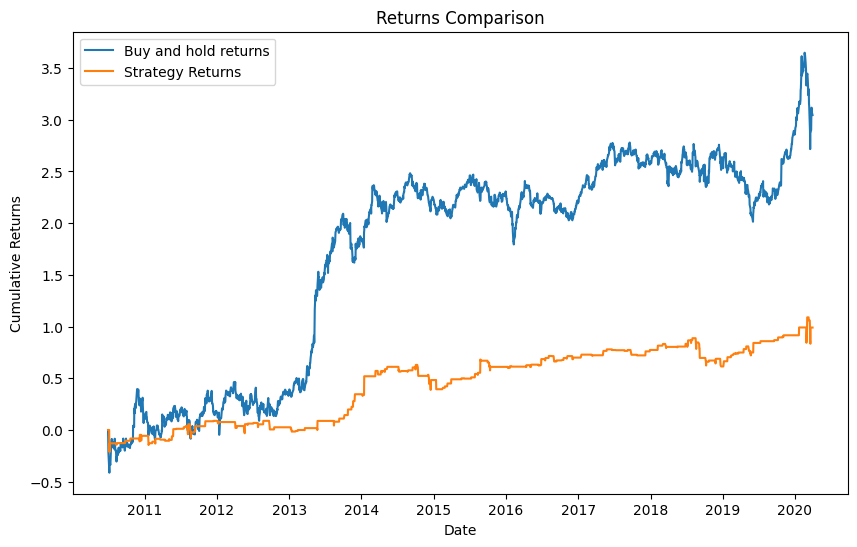

In [14]:
bnh = data['cc_returns'].cumsum()
s_returns = data['strategy_returns'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(bnh, label='Buy and hold returns')
plt.plot(s_returns, label='Strategy Returns')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.title('Returns Comparison')
plt.legend()
plt.show()

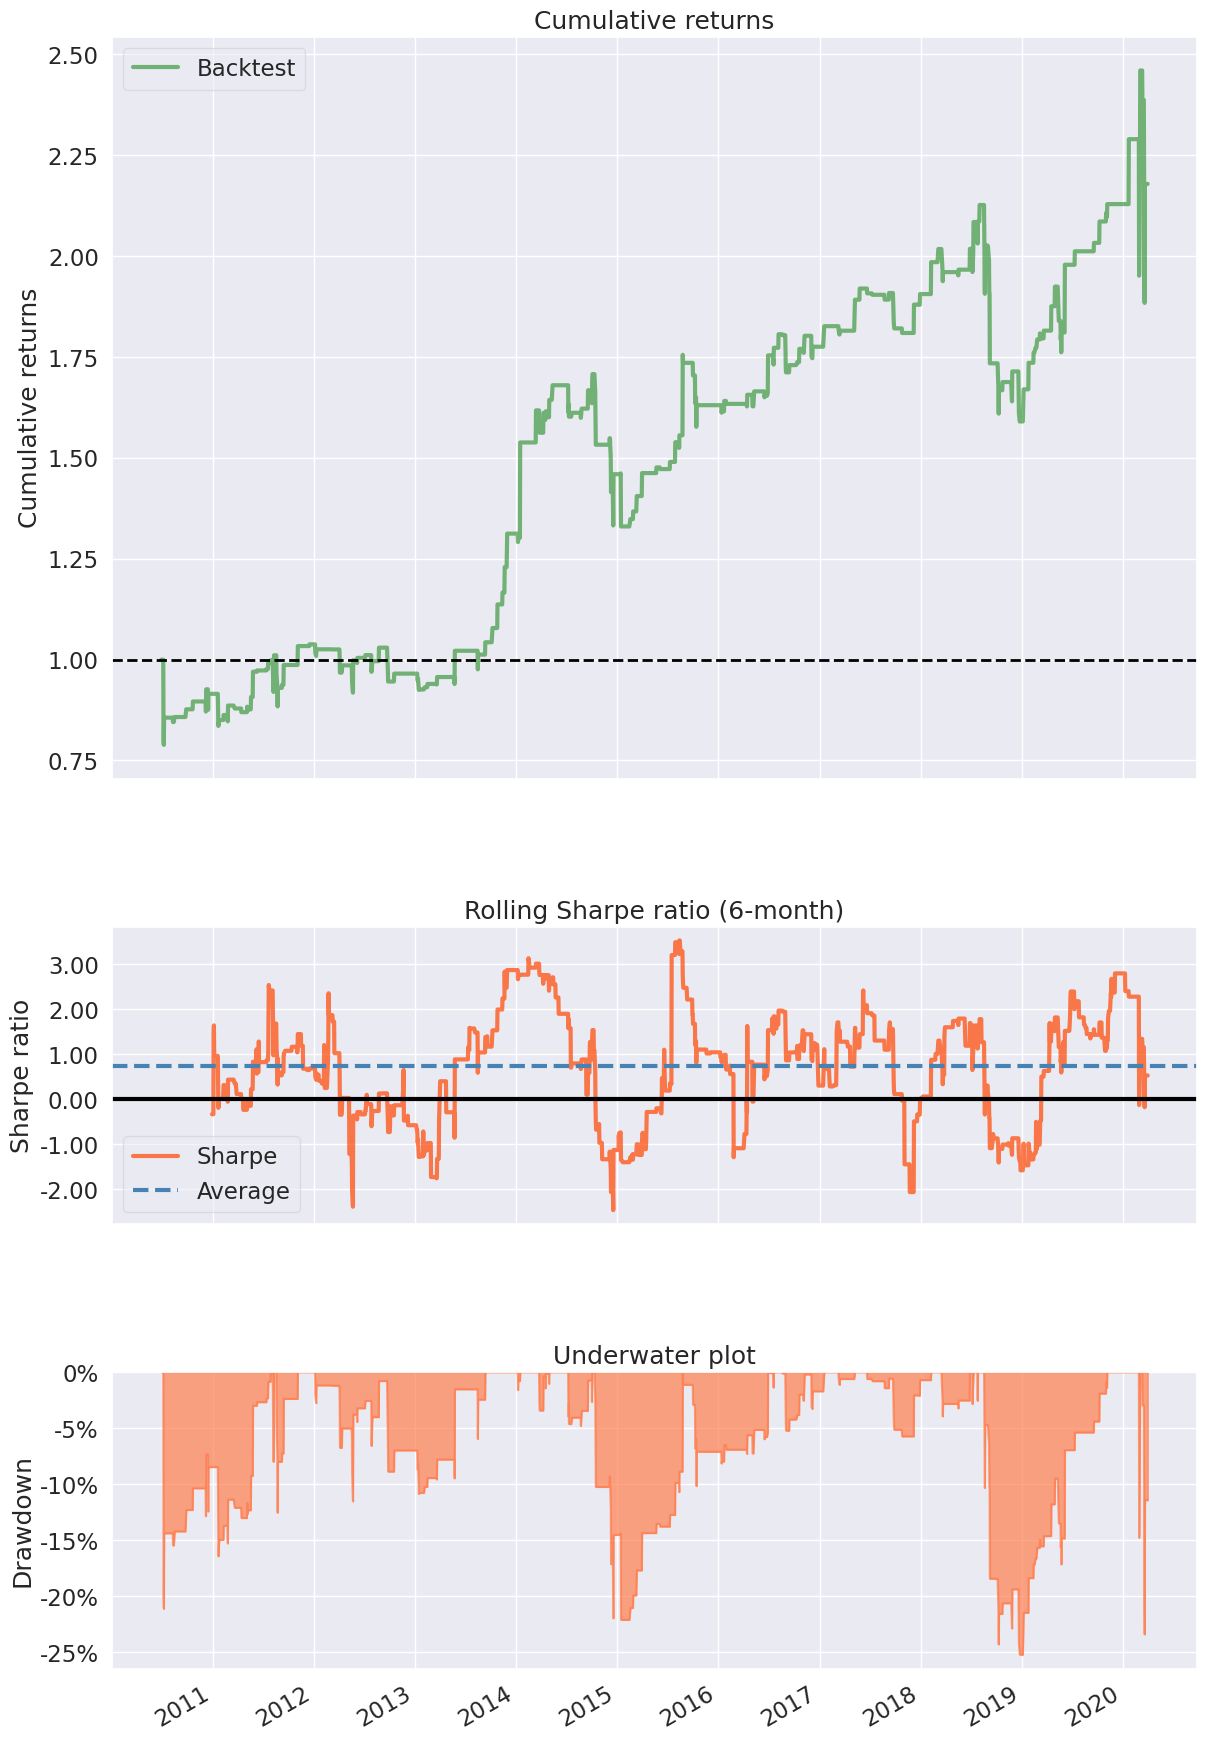

In [15]:
# Get the summary statistics for the strategy using pyfolio
pf.create_simple_tear_sheet(data['strategy_returns'])

Optional: Optimize the strategy by exiting the long position on the same day close.

In [16]:
# Compute strategy returns
data['oc_strategy_returns'] = data['signals'] * data['oc_returns']

# Print returns
print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
print('Strategy returns: ', np.round(data['oc_strategy_returns'].cumsum()[-1], 2))

Buy and hold returns:  3.05
Strategy returns:  0.66


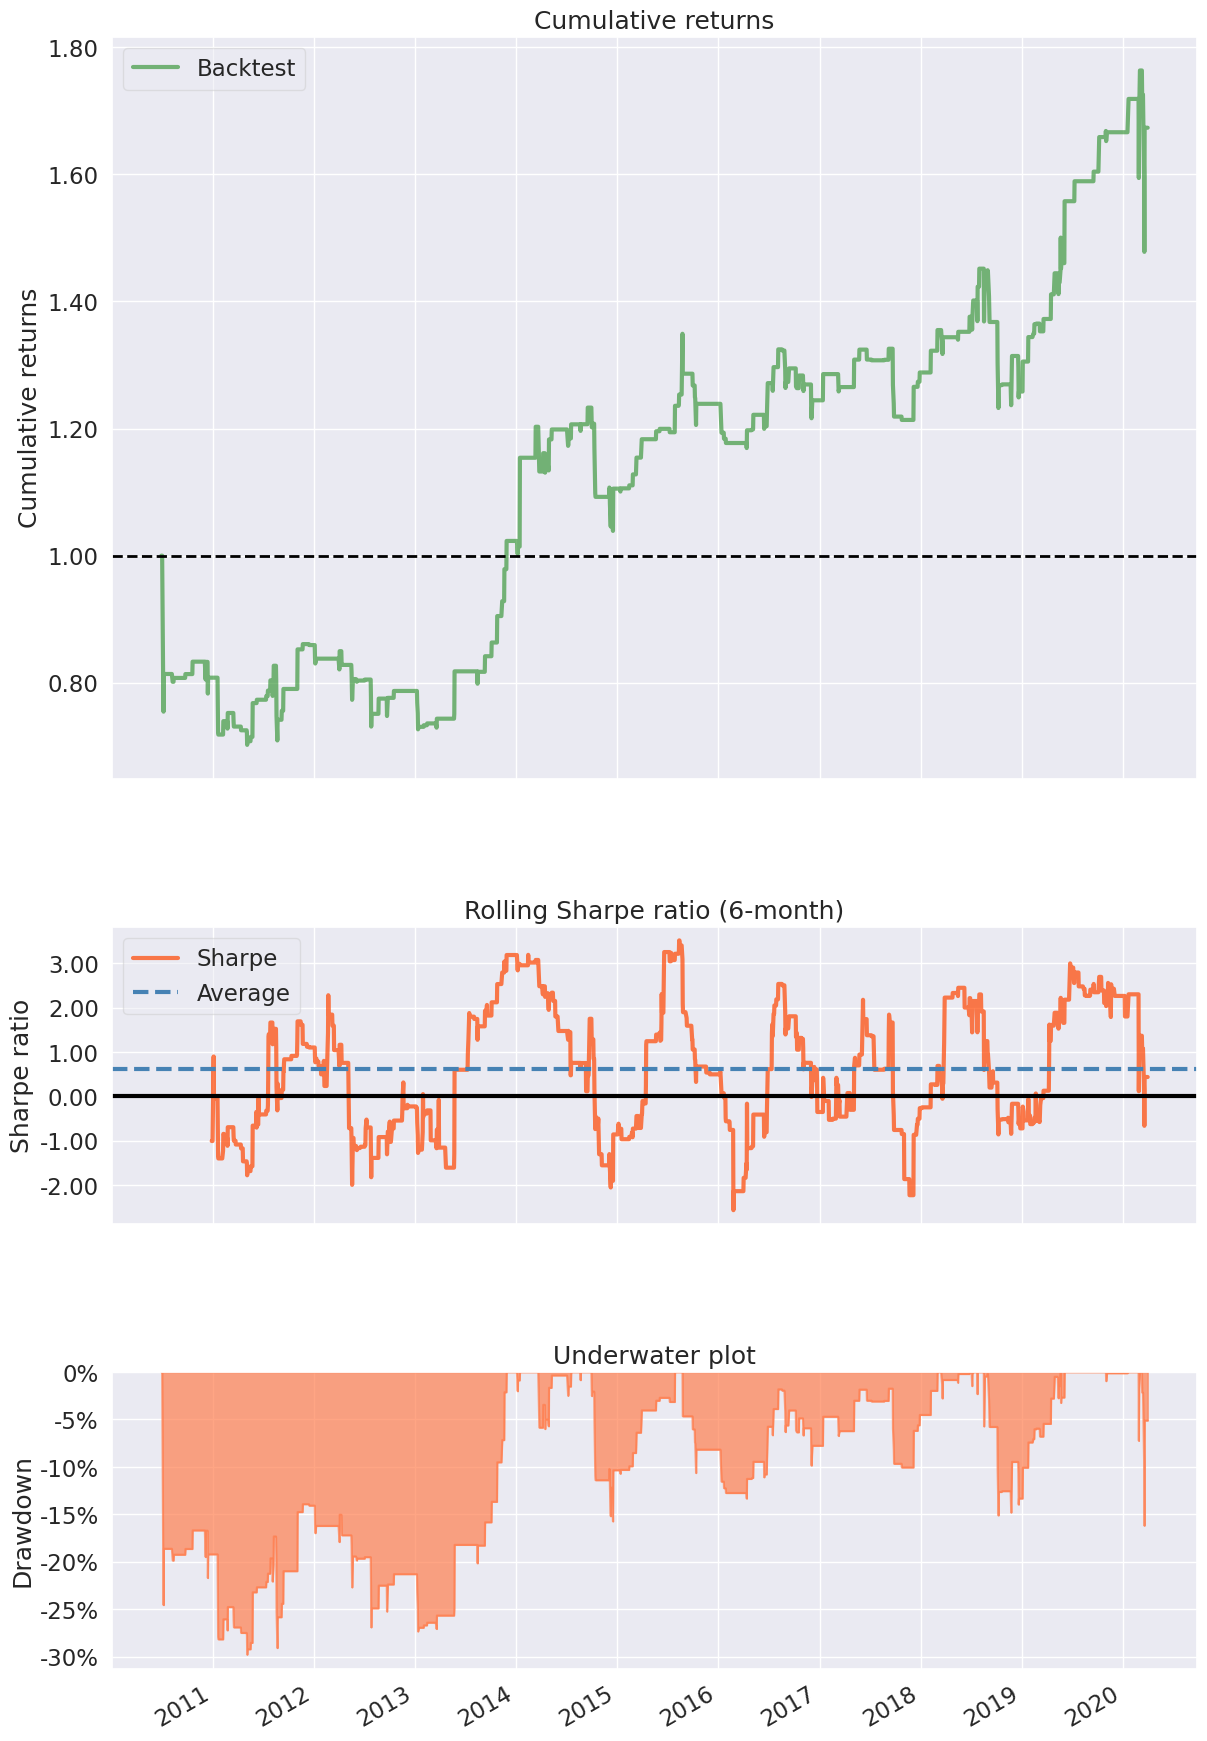

In [17]:
# Get the summary statistics for the strategy using pyfolio
pf.create_simple_tear_sheet(data['oc_strategy_returns'])

## Problem III - Strategy based on RSI indicator.
1. Buy the instrument such as Nifty or SPY when the RSI is less than 30
2. Exit conditions:
    a. Take profit of 5% or RSI > 70,
    b. Stop loss of - 2%
3. Optional: Optimize the strategy by adjusting the RSI value. Also, take profit and stop loss criteria can be different for each stock.
4. Note: You can use TA-Lib in Python to compute the RSI value.

In [18]:
# Importing the necessary libraries
import talib
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


# start date
start = datetime.datetime(2010, 2, 25)
# end date
end = datetime.datetime(2020, 2, 25)


# Getting data from SPY (SPR S&P500 ETF)
df1 = yf.download('SPY', start, end, group_by = 'ticker')['SPY']

[*********************100%***********************]  1 of 1 completed


In [19]:
df1.shape[1]

5

**Data preprocessing**

In [20]:
# Making a copy to work with
SPY = df1.copy()

# Calculating RSI using talib
SPY['RSI'] = talib.RSI(SPY['Close'])

# Dropping NaN values and resetting the index(this will help in data manipulation)
SPY.dropna(inplace=True, axis=0)
SPY = SPY.reset_index()

SPY.head()

Date       Open       High        Low      Close     Volume  \
0 2010-03-17  90.448877  91.006631  90.185491  90.712257  177468100   
1 2010-03-18  90.719982  90.843924  90.301667  90.665756  196509100   
2 2010-03-19  90.206810  91.233567  89.856776  90.206810  226641100   
3 2010-03-22  89.693407  90.852402  89.638958  90.689049  184477800   
4 2010-03-23  90.821334  91.404718  90.525748  91.326935  182941600   

          RSI  
0  100.000000  
1   99.004636  
2   89.532552  
3   90.555076  
4   91.708832

**Defining a function for backtesting, based on the conditions mentioned in the question statement**

In [21]:
def backtesting_RSI(df, TP_level, SL_level):
    '''
    This function backtests the following RSI strategy:

    - Entry condition:
      Buy the instrument when the RSI is less than 30

    - Exit conditions: 
      a. Take profit level is hit or
      b. RSI > 70 or
      c. Stop loss level is hit

    This function takes in three arguments:

    df: The DataFrame containing daily stock data (in a Yahoo finance format) along with the 14 day RSI column

    TP_level: Take profit level in percent

    SL_level: Stop loss level in percent

    Note: You can add other summary metrics such as Sharpe ratio, Max DD etc. to this function 

    '''

    # Initializing four new columns
    df['trade_price'] = 0
    df['RSI_signal'] = 0
    df['take_profit_price'] = 0
    df['stop_loss_price'] = 0
    
    # Defining the length of the dataframe df
    n = df.shape[0]

    # The for-loop to create signals based on RSI only
    # We're going to run the whole loop on each row
    for i in range(1, n): 

        # Check if we have no position in the asset
        if df['RSI_signal'].iloc[i-1] == 0:
            # Check if we need to go long for today
            if df['RSI'].iloc[i] <= 30:
                # In case the RSI is below 30, then we do the following:
                # We assign the RSI_signal to 1, i.e. we go long
                df['RSI_signal'].iloc[i] = 1
                # We assign to the trade price the close price
                df['trade_price'].iloc[i] = df['Close'].iloc[i]
                # We create our take profit target
                df['take_profit_price'].iloc[i] = df['trade_price'].iloc[i]*(1 + TP_level)
                # We create our stop-loss target
                df['stop_loss_price'].iloc[i] = df['trade_price'].iloc[i]*(1 - SL_level)
            
            # If the RSI is higher than 30, we do nothing
            else:
                # We copy today's Close price on today's trade price
                df['trade_price'].iloc[i] = df['Close'].iloc[i]  
        
        # Check if we have a long position in the previous day
        elif df['RSI_signal'].iloc[i-1] == 1:
                
            # Check if today we breached the stop-loss target
            if df['Low'].iloc[i] < df['stop_loss_price'].iloc[i-1]:
                # If it's true, then we assign today's RSI_signal to zero, i.e. square off the position
                df['RSI_signal'].iloc[i] = 0
                # We assign to the trade price the stop loss price
                df['trade_price'].iloc[i] = df['stop_loss_price'].iloc[i-1]
                # We change the take profit price to 0 because we squared off the position
                df['take_profit_price'].iloc[i] = 0
                # We change the stop loss price to 0 because we squared off the position
                df['stop_loss_price'].iloc[i] = 0

            # Check if today we breach the take profit target
            elif df['High'].iloc[i] > df['take_profit_price'].iloc[i-1]:
                # If it's true, then we assign today's RSI_signal to zero, i.e. square off the position
                df['RSI_signal'].iloc[i] = 0
                # We assign to the trade price the take profit price
                df['trade_price'].iloc[i] = df['take_profit_price'].iloc[i-1]
                # We change the take profit price to 0 because we squared off the position
                df['take_profit_price'].iloc[i] = 0
                # We change the stop loss price to 0 because we squared off the position
                df['stop_loss_price'].iloc[i] = 0

            # Check if today we breach the RSI take profit target for the long position           
            elif df['RSI'].iloc[i] >= 70:
                # If it's true, then we assign today's RSI_signal to zero, i.e. square off the position
                df['RSI_signal'].iloc[i] = 0
                # We assign to the trade price the close price
                df['trade_price'].iloc[i] = df['Close'].iloc[i]
                # We change the take profit price to 0 because we squared off the position
                df['take_profit_price'].iloc[i] = 0
                # We change the stop loss price to 0 because we squared off the position
                df['stop_loss_price'].iloc[i] = 0

            # If we don't breach today either the stop loss or the take profit targets, 
            # then we just repeat the values from yesterday for today's values
            else:
                df['RSI_signal'].iloc[i] = df['RSI_signal'].iloc[i-1]
                df['trade_price'].iloc[i] = df['Close'].iloc[i]
                df['take_profit_price'].iloc[i] = df['take_profit_price'].iloc[i-1]
                df['stop_loss_price'].iloc[i] = df['stop_loss_price'].iloc[i-1]

    # Visualizing the strategy with position overlaid on RSI
    y = df['RSI'].plot(figsize=(30, 10))
    l1 = np.array([30 for i in range(n)])
    l2 = np.array([70 for i in range(n)])
    plt.plot(l1)
    plt.plot(l2)
    df['RSI_signal'].plot(ax=y, secondary_y='position')
    plt.title('Visualizing the strategy with position overlaid on RSI')
    plt.show()

    # Calculating and plotting strategy returns
    df['daily_log_returns'] = np.log(df['Close']/df['Close'].shift())
    df['strategy_returns'] = df['daily_log_returns']*df['RSI_signal'].shift()
    df['cumulative_strategy_returns'] = df['strategy_returns'].cumsum().apply(np.exp)
    print('total return from this strategy:', np.exp(df['strategy_returns'].sum()))
    df['cumulative_strategy_returns'].plot()
    plt.title('Cumulative returns for this strategy')
    plt.show()

    return df

**Using the function to backtest the strategy on the SPY data with**
* TP level set at 5% or 0.05 and
* SL level at 2% or 0.02

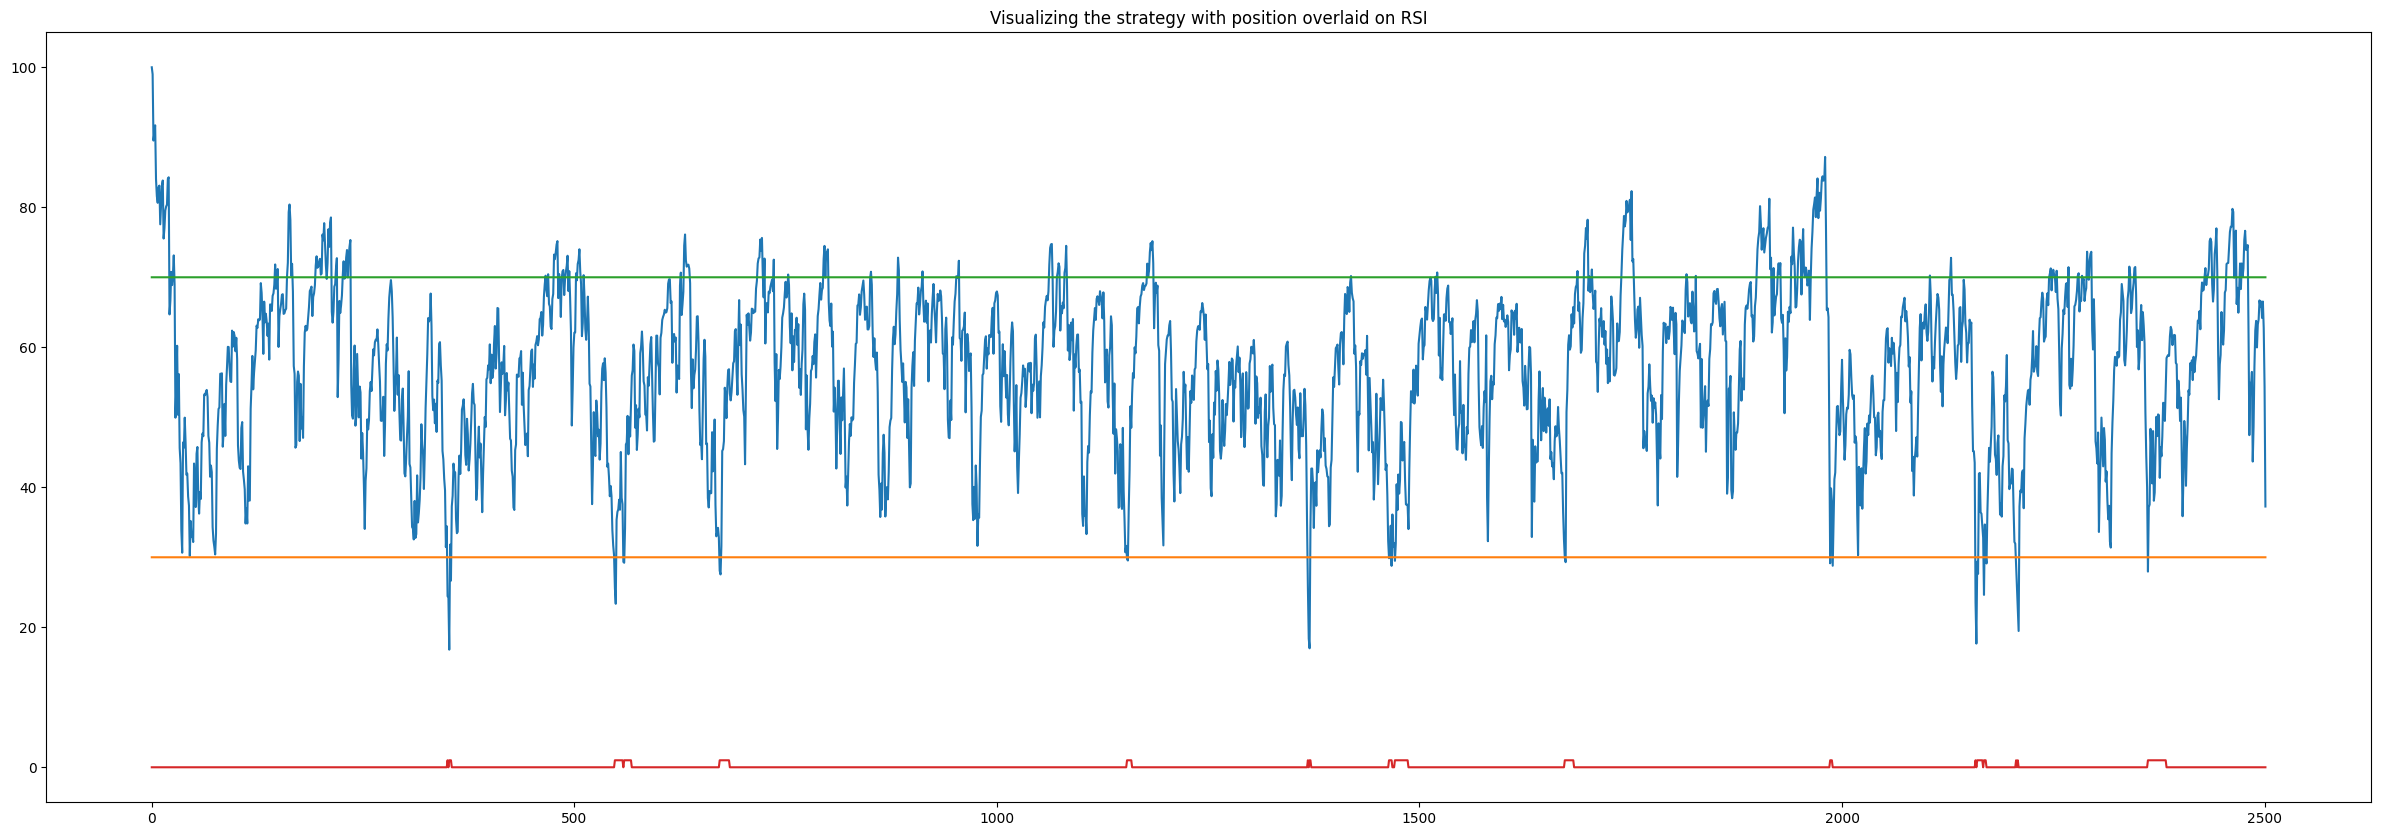

total return from this strategy: 1.163526654425615


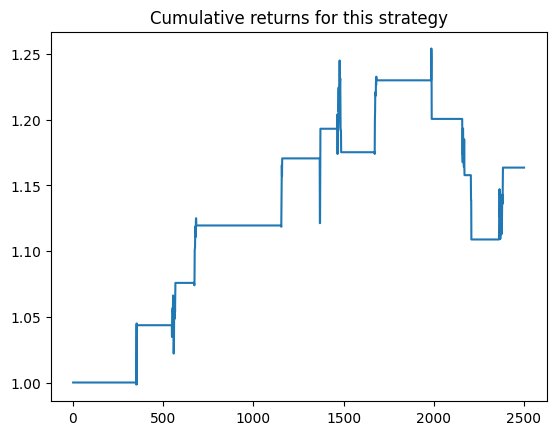

In [22]:
df_rsi = backtesting_RSI(SPY, TP_level=0.05, SL_level=0.02)

<Axes: >

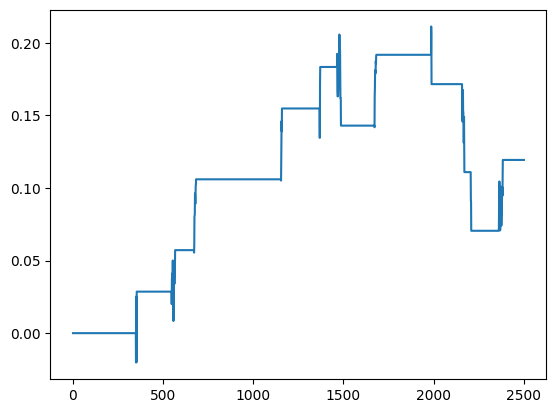

In [23]:
# Plot cumulative returns using the trade price column
(np.log(df_rsi['trade_price']/df_rsi['trade_price'].shift(1))*df_rsi['RSI_signal'].shift(1)).cumsum().plot()

## Problem IV - Backtest the strategy based on the turtle trading system covered in EFS-02 class.

You can use the daily data for backtesting purpose. Also, the event-driven approach covered in DMP-01 and DMP-03 would be best for this scenario.

In [24]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import pyfolio as pf

In [25]:
# setup
symbol = 'MSFT'
start = '2010-01-01'
end = '2022-12-31'
source = 'yahoo'
ndays_high = 3
ndays_low = 3
nATR = 20
SL = 1  # Stop loss: number of ATR to stop loss
TP = 2  # Take profit: number of ATR to take profit
equity = 10000

# retrieving data from Yahoo
df = yf.download(symbol, start, end, group_by = "ticker")[symbol]
df.tail(3)

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close    Volume
Date                                                                
2022-12-28  235.284558  238.095381  232.582991  232.940552  17457100
2022-12-29  234.052958  240.280469  234.052958  239.376633  19770700
2022-12-30  236.595613  238.333753  235.056114  238.194702  21938500

In [26]:
# Compute the ATR indicator
df['ATR'] = ta.ATR(high=df.High, low=df.Low,
                   close=df.Close, timeperiod=nATR).shift(1)
# Compute the repeated ATR
df['rep_ATR'] = 0.0
df.tail(5)

Open        High         Low       Close    Volume  \
Date                                                                   
2022-12-23  234.509852  237.251142  232.354560  237.112091  21207000   
2022-12-27  237.082294  237.310731  234.231749  235.354095  16688600   
2022-12-28  235.284558  238.095381  232.582991  232.940552  17457100   
2022-12-29  234.052958  240.280469  234.052958  239.376633  19770700   
2022-12-30  236.595613  238.333753  235.056114  238.194702  21938500   

                 ATR  rep_ATR  
Date                           
2022-12-23  7.024965      0.0  
2022-12-27  6.918545      0.0  
2022-12-28  6.726567      0.0  
2022-12-29  6.665858      0.0  
2022-12-30  6.699561      0.0

In [27]:
df['SL_price'] = df['TP_price'] = 0.0

In [28]:
# Drop the na required to compute the ATR
df.dropna(inplace=True)

In [29]:
# Compute the moving last n highest high and lowest low
df['ndays_high'] = df['High'].rolling(ndays_high).max().shift(1)
df['ndays_low'] = df['Low'].rolling(ndays_low).min().shift(1)
df.tail(5)

Open        High         Low       Close    Volume  \
Date                                                                   
2022-12-23  234.509852  237.251142  232.354560  237.112091  21207000   
2022-12-27  237.082294  237.310731  234.231749  235.354095  16688600   
2022-12-28  235.284558  238.095381  232.582991  232.940552  17457100   
2022-12-29  234.052958  240.280469  234.052958  239.376633  19770700   
2022-12-30  236.595613  238.333753  235.056114  238.194702  21938500   

                 ATR  rep_ATR  SL_price  TP_price  ndays_high   ndays_low  
Date                                                                       
2022-12-23  7.024965      0.0       0.0       0.0  243.955390  232.285015  
2022-12-27  6.918545      0.0       0.0       0.0  243.955390  232.285015  
2022-12-28  6.726567      0.0       0.0       0.0  240.349994  232.285015  
2022-12-29  6.665858      0.0       0.0       0.0  238.095381  232.354560  
2022-12-30  6.699561      0.0       0.0       0.0  240.280469  232.582991

In [30]:
# Run strategy
df['signal'] = ""
df['position'] = 0.0
df['trade_price'] = 0.0
df['trade_ret'] = 0.0

for i in range(1, len(df)):

    if df.iloc[i-1].position == 0.0:
        # Entry long
        if df.iloc[i].High > df.iloc[i].ndays_high:
            print(i, str(df.index[i].date()), "Entry long, price", df.iloc[i].Close)
            df.position.iloc[i] = 1.0
            df.trade_price.iloc[i] = df.iloc[i].ndays_high
            df.signal.iloc[i] = "Entry long"
            if (df.iloc[i].position == df.iloc[i-1].position):
                df.rep_ATR.iloc[i] = df.rep_ATR.iloc[i-1]
            elif df.position.iloc[i] == 1:
                df.rep_ATR.iloc[i] = df.ATR.iloc[i] 
            df.SL_price = df.iloc[i].trade_price - df.iloc[i].rep_ATR * SL
            df.TP_price = df.iloc[i].trade_price + df.iloc[i].rep_ATR * TP
        # Entry short
        elif df.iloc[i].Low < df.iloc[i].ndays_low:
            print(i, str(df.index[i].date()), "Entry short, price", df.iloc[i].Close)
            df.position.iloc[i] = -1.0
            df.trade_price.iloc[i] = df.iloc[i].ndays_low
            df.signal.iloc[i] = "Entry short"
            if (df.iloc[i].position == df.iloc[i-1].position):
                df.rep_ATR.iloc[i] = df.rep_ATR.iloc[i-1]
            elif df.position.iloc[i] == -1:
                df.rep_ATR.iloc[i] = df.ATR.iloc[i]
            df.SL_price = df.iloc[i].trade_price + df.iloc[i].rep_ATR * SL
            df.TP_price = df.iloc[i].trade_price - df.iloc[i].rep_ATR * TP
            
    # Check take profit and stop loss for long position
    elif df.iloc[i-1].position == 1.0:
        if df.iloc[i].Close <= df.iloc[i-1].SL_price:
            print(i, str(df.index[i].date()),
                  "Long position Stop loss price", df.iloc[i-1].SL_price)
            df.position.iloc[i] = 0.0
            df.trade_price.iloc[i] = df.iloc[i-1].SL_price
            df.trade_ret.iloc[i] = df.trade_price.iloc[i] / df.iloc[i-1].trade_price - 1
            df.signal.iloc[i] = "SL long"
        elif df.iloc[i].Close >= df.iloc[i-1].TP_price:
            print(i, str(df.index[i].date()),
                  "Long position Take profit price", df.iloc[i-1].TP_price)
            df.position.iloc[i] = 0.0
            df.trade_price.iloc[i] = df.iloc[i-1].TP_price
            df.trade_ret.iloc[i] = df.trade_price.iloc[i] / df.iloc[i-1].trade_price - 1
            df.signal.iloc[i] = "TP long"
        else:
            print(i, str(df.index[i].date()), "Carry position")
            df.position.iloc[i] = df.iloc[i-1].position
            df.trade_price.iloc[i] = df.iloc[i-1].trade_price   
            df.signal.iloc[i] = df.signal.iloc[i-1]

    # Check take profit and stop loss for short position
    elif df.iloc[i-1].position == -1.0:
        if df.iloc[i].Close >= df.iloc[i-1].SL_price:
            print(i, str(df.index[i].date()),
                  "Short position Stop loss price", df.iloc[i-1].SL_price)
            df.position.iloc[i] = 0.0
            df.trade_price.iloc[i] = df.iloc[i-1].SL_price
            df.trade_ret.iloc[i] = np.exp(np.log(df.trade_price.iloc[i] / df.iloc[i-1].trade_price)*(-1)) - 1
            df.signal.iloc[i] = "SL short"
        elif df.iloc[i].Close <= df.iloc[i-1].TP_price:
            print(i, str(df.index[i].date()),
                  "Short position Take profit price", df.iloc[i-1].TP_price)
            df.position.iloc[i] = 0.0
            df.trade_price.iloc[i] = df.iloc[i-1].TP_price
            df.trade_ret.iloc[i] = np.exp(np.log(df.trade_price.iloc[i] / df.iloc[i-1].trade_price)*(-1)) - 1
            df.signal.iloc[i] = "TP short"
        else:
            print(i, str(df.index[i].date()), "Carry position")
            df.position.iloc[i] = df.iloc[i-1].position
            df.trade_price.iloc[i] = df.iloc[i-1].trade_price   
            df.signal.iloc[i] = df.signal.iloc[i-1]


6 2010-02-11 Entry long, price 21.37171173095703
7 2010-02-12 Carry position
8 2010-02-16 Carry position
9 2010-02-17 Carry position
10 2010-02-18 Carry position
11 2010-02-19 Carry position
12 2010-02-22 Carry position
13 2010-02-23 Carry position
14 2010-02-24 Carry position
15 2010-02-25 Carry position
16 2010-02-26 Carry position
17 2010-03-01 Carry position
18 2010-03-02 Carry position
19 2010-03-03 Carry position
20 2010-03-04 Carry position
21 2010-03-05 Carry position
22 2010-03-08 Carry position
23 2010-03-09 Carry position
24 2010-03-10 Carry position
25 2010-03-11 Carry position
26 2010-03-12 Carry position
27 2010-03-15 Carry position
28 2010-03-16 Carry position
29 2010-03-17 Carry position
30 2010-03-18 Carry position
31 2010-03-19 Carry position
32 2010-03-22 Carry position
33 2010-03-23 Long position Take profit price 22.629110192983624
35 2010-03-25 Entry long, price 22.914806365966797
36 2010-03-26 Carry position
37 2010-03-29 Carry position
38 2010-03-30 Carry positi

2838 2001-04-26 00:00:00 Entry long, price 21.619060516357422
2839 2001-04-27 00:00:00 Stop loss short, price 21.306793331875845
2842 2001-05-02 00:00:00 Entry long, price 21.816082000732422
2843 2001-05-03 00:00:00 Carry position
2844 2001-05-04 00:00:00 Carry position
2845 2001-05-07 00:00:00 Carry position
2846 2001-05-08 00:00:00 Carry position
2847 2001-05-09 00:00:00 Carry position
2848 2001-05-10 00:00:00 Carry position
2849 2001-05-11 00:00:00 Carry position
2850 2001-05-14 00:00:00 Carry position
2851 2001-05-15 00:00:00 Stop loss short, price 21.49438650356199
2852 2001-05-16 00:00:00 Entry short, price 21.628448486328125
2853 2001-05-17 00:00:00 Carry position
2854 2001-05-18 00:00:00 Carry position
2855 2001-05-21 00:00:00 Carry position
2856 2001-05-22 00:00:00 Stop loss short, price 21.79271707255325
2857 2001-05-23 00:00:00 Entry long, price 21.79731559753418
2858 2001-05-24 00:00:00 Carry position
2859 2001-05-25 00:00:00 Carry position
2860 2001-05-29 00:00:00 Carry po

3067 2002-04-01 00:00:00 Carry position
3068 2002-04-02 00:00:00 Take profit short, price 17.97237769450046
3069 2002-04-03 00:00:00 Entry short, price 17.616106033325195
3070 2002-04-04 00:00:00 Carry position
3071 2002-04-05 00:00:00 Carry position
3072 2002-04-08 00:00:00 Carry position
3073 2002-04-09 00:00:00 Carry position
3074 2002-04-10 00:00:00 Carry position
3075 2002-04-11 00:00:00 Carry position
3076 2002-04-12 00:00:00 Carry position
3077 2002-04-15 00:00:00 Carry position
3078 2002-04-16 00:00:00 Stop loss short, price 17.94300002741373
3079 2002-04-17 00:00:00 Entry long, price 17.709922790527344
3080 2002-04-18 00:00:00 Stop loss short, price 17.63176288960798
3084 2002-04-24 00:00:00 Entry short, price 16.580974578857422
3085 2002-04-25 00:00:00 Carry position
3086 2002-04-26 00:00:00 Carry position
3087 2002-04-29 00:00:00 Carry position
3088 2002-04-30 00:00:00 Carry position
3089 2002-05-01 00:00:00 Carry position
3090 2002-05-02 00:00:00 Carry position
3091 2002-05

3480 2003-11-17 00:00:00 Carry position
3481 2003-11-18 00:00:00 Carry position
3482 2003-11-19 00:00:00 Carry position
3483 2003-11-20 00:00:00 Carry position
3484 2003-11-21 00:00:00 Carry position
3485 2003-11-24 00:00:00 Carry position
3486 2003-11-25 00:00:00 Carry position
3487 2003-11-26 00:00:00 Carry position
3488 2003-11-28 00:00:00 Carry position
3489 2003-12-01 00:00:00 Carry position
3490 2003-12-02 00:00:00 Carry position
3491 2003-12-03 00:00:00 Carry position
3492 2003-12-04 00:00:00 Carry position
3493 2003-12-05 00:00:00 Carry position
3494 2003-12-08 00:00:00 Carry position
3495 2003-12-09 00:00:00 Carry position
3496 2003-12-10 00:00:00 Stop loss short, price 16.75179988862502
3497 2003-12-11 00:00:00 Entry long, price 16.790706634521484
3498 2003-12-12 00:00:00 Carry position
3499 2003-12-15 00:00:00 Carry position
3500 2003-12-16 00:00:00 Carry position
3501 2003-12-17 00:00:00 Carry position
3502 2003-12-18 00:00:00 Carry position
3503 2003-12-19 00:00:00 Carry p

3829 2005-04-08 00:00:00 Carry position
3830 2005-04-11 00:00:00 Carry position
3831 2005-04-12 00:00:00 Carry position
3832 2005-04-13 00:00:00 Carry position
3833 2005-04-14 00:00:00 Carry position
3834 2005-04-15 00:00:00 Stop loss short, price 17.4048066558627
3835 2005-04-18 00:00:00 Entry short, price 17.440296173095703
3836 2005-04-19 00:00:00 Carry position
3837 2005-04-20 00:00:00 Carry position
3838 2005-04-21 00:00:00 Stop loss short, price 17.51427450263726
3842 2005-04-27 00:00:00 Entry short, price 17.680856704711914
3843 2005-04-28 00:00:00 Carry position
3844 2005-04-29 00:00:00 Stop loss short, price 17.720203801224017
3845 2005-05-02 00:00:00 Entry long, price 17.85066032409668
3846 2005-05-03 00:00:00 Carry position
3847 2005-05-04 00:00:00 Carry position
3848 2005-05-05 00:00:00 Carry position
3849 2005-05-06 00:00:00 Carry position
3850 2005-05-09 00:00:00 Carry position
3851 2005-05-10 00:00:00 Stop loss short, price 17.658601660810337
3852 2005-05-11 00:00:00 Ent

4070 2006-03-23 00:00:00 Entry short, price 19.234621047973633
4071 2006-03-24 00:00:00 Carry position
4072 2006-03-27 00:00:00 Carry position
4073 2006-03-28 00:00:00 Carry position
4074 2006-03-29 00:00:00 Carry position
4075 2006-03-30 00:00:00 Stop loss short, price 19.398033435482127
4076 2006-03-31 00:00:00 Entry long, price 19.49250030517578
4077 2006-04-03 00:00:00 Carry position
4078 2006-04-04 00:00:00 Carry position
4079 2006-04-05 00:00:00 Carry position
4080 2006-04-06 00:00:00 Carry position
4081 2006-04-07 00:00:00 Carry position
4082 2006-04-10 00:00:00 Carry position
4083 2006-04-11 00:00:00 Stop loss short, price 19.441265187852586
4084 2006-04-12 00:00:00 Entry short, price 19.48534393310547
4085 2006-04-13 00:00:00 Carry position
4086 2006-04-17 00:00:00 Carry position
4087 2006-04-18 00:00:00 Carry position
4088 2006-04-19 00:00:00 Carry position
4089 2006-04-20 00:00:00 Carry position
4090 2006-04-21 00:00:00 Carry position
4091 2006-04-24 00:00:00 Carry position


4644 2008-07-03 00:00:00 Carry position
4645 2008-07-07 00:00:00 Carry position
4646 2008-07-08 00:00:00 Carry position
4647 2008-07-09 00:00:00 Carry position
4648 2008-07-10 00:00:00 Carry position
4649 2008-07-11 00:00:00 Carry position
4650 2008-07-14 00:00:00 Carry position
4651 2008-07-15 00:00:00 Carry position
4652 2008-07-16 00:00:00 Stop loss short, price 19.724009907325968
4653 2008-07-17 00:00:00 Entry long, price 20.356229782104492
4654 2008-07-18 00:00:00 Stop loss short, price 20.042752428652268
4657 2008-07-23 00:00:00 Entry long, price 19.549972534179688
4658 2008-07-24 00:00:00 Stop loss short, price 19.210540184258083
4660 2008-07-28 00:00:00 Entry short, price 18.862058639526367
4661 2008-07-29 00:00:00 Carry position
4662 2008-07-30 00:00:00 Stop loss short, price 19.382652010918807
4664 2008-08-01 00:00:00 Entry short, price 18.817676544189453
4665 2008-08-04 00:00:00 Carry position
4666 2008-08-05 00:00:00 Stop loss short, price 19.149341099630394
4667 2008-08-06

4840 2009-04-15 00:00:00 Carry position
4841 2009-04-16 00:00:00 Carry position
4842 2009-04-17 00:00:00 Carry position
4843 2009-04-20 00:00:00 Carry position
4844 2009-04-21 00:00:00 Carry position
4845 2009-04-22 00:00:00 Carry position
4846 2009-04-23 00:00:00 Carry position
4847 2009-04-24 00:00:00 Take profit long, price 15.677045883769802
4851 2009-04-30 00:00:00 Entry long, price 15.251646995544434
4852 2009-05-01 00:00:00 Stop loss short, price 15.270983154569434
4854 2009-05-05 00:00:00 Entry short, price 14.89783763885498
4855 2009-05-06 00:00:00 Carry position
4856 2009-05-07 00:00:00 Carry position
4857 2009-05-08 00:00:00 Carry position
4858 2009-05-11 00:00:00 Carry position
4859 2009-05-12 00:00:00 Carry position
4860 2009-05-13 00:00:00 Carry position
4861 2009-05-14 00:00:00 Carry position
4862 2009-05-15 00:00:00 Carry position
4863 2009-05-18 00:00:00 Stop loss short, price 15.313660984636924
4864 2009-05-19 00:00:00 Entry long, price 15.386384963989258
4865 2009-05

5183 2010-08-24 00:00:00 Carry position
5184 2010-08-25 00:00:00 Carry position
5185 2010-08-26 00:00:00 Carry position
5186 2010-08-27 00:00:00 Carry position
5187 2010-08-30 00:00:00 Carry position
5188 2010-08-31 00:00:00 Carry position
5189 2010-09-01 00:00:00 Carry position
5190 2010-09-02 00:00:00 Carry position
5191 2010-09-03 00:00:00 Carry position
5192 2010-09-07 00:00:00 Carry position
5193 2010-09-08 00:00:00 Carry position
5194 2010-09-09 00:00:00 Carry position
5195 2010-09-10 00:00:00 Carry position
5196 2010-09-13 00:00:00 Stop loss short, price 19.152846649688758
5197 2010-09-14 00:00:00 Entry long, price 19.432567596435547
5198 2010-09-15 00:00:00 Carry position
5199 2010-09-16 00:00:00 Carry position
5200 2010-09-17 00:00:00 Carry position
5201 2010-09-20 00:00:00 Carry position
5202 2010-09-21 00:00:00 Carry position
5203 2010-09-22 00:00:00 Stop loss short, price 19.306832499592186
5206 2010-09-27 00:00:00 Entry long, price 19.19965362548828
5207 2010-09-28 00:00:0

5524 2011-12-29 00:00:00 Carry position
5525 2011-12-30 00:00:00 Carry position
5526 2012-01-03 00:00:00 Take profit long, price 21.29809565676426
5527 2012-01-04 00:00:00 Entry long, price 21.971893310546875
5528 2012-01-05 00:00:00 Carry position
5529 2012-01-06 00:00:00 Carry position
5530 2012-01-09 00:00:00 Carry position
5531 2012-01-10 00:00:00 Carry position
5532 2012-01-11 00:00:00 Carry position
5533 2012-01-12 00:00:00 Carry position
5534 2012-01-13 00:00:00 Carry position
5535 2012-01-17 00:00:00 Carry position
5536 2012-01-18 00:00:00 Carry position
5537 2012-01-19 00:00:00 Carry position
5538 2012-01-20 00:00:00 Take profit long, price 22.807487603484283
5539 2012-01-23 00:00:00 Entry long, price 23.840309143066406
5540 2012-01-24 00:00:00 Stop loss short, price 23.57923210166442
5544 2012-01-30 00:00:00 Entry short, price 23.744075775146484
5545 2012-01-31 00:00:00 Stop loss short, price 23.551265863753873
5546 2012-02-01 00:00:00 Entry long, price 23.968608856201172
554

5831 2013-03-22 00:00:00 Carry position
5832 2013-03-25 00:00:00 Carry position
5833 2013-03-26 00:00:00 Carry position
5834 2013-03-27 00:00:00 Carry position
5835 2013-03-28 00:00:00 Carry position
5836 2013-04-01 00:00:00 Carry position
5837 2013-04-02 00:00:00 Carry position
5838 2013-04-03 00:00:00 Carry position
5839 2013-04-04 00:00:00 Carry position
5840 2013-04-05 00:00:00 Carry position
5841 2013-04-08 00:00:00 Carry position
5842 2013-04-09 00:00:00 Take profit long, price 24.127929703234766
5843 2013-04-10 00:00:00 Entry long, price 25.174768447875977
5844 2013-04-11 00:00:00 Stop loss short, price 24.848239848285505
5845 2013-04-12 00:00:00 Entry short, price 23.93597984313965
5846 2013-04-15 00:00:00 Carry position
5847 2013-04-16 00:00:00 Carry position
5848 2013-04-17 00:00:00 Carry position
5849 2013-04-18 00:00:00 Carry position
5850 2013-04-19 00:00:00 Stop loss short, price 24.225381031391052
5851 2013-04-22 00:00:00 Entry long, price 25.632038116455078
5852 2013-04

6033 2014-01-09 00:00:00 Entry short, price 30.183547973632812
6034 2014-01-10 00:00:00 Stop loss short, price 30.586970109933112
6035 2014-01-13 00:00:00 Entry short, price 29.716320037841797
6036 2014-01-14 00:00:00 Stop loss short, price 30.129064879056425
6037 2014-01-15 00:00:00 Entry long, price 31.22846794128418
6038 2014-01-16 00:00:00 Carry position
6039 2014-01-17 00:00:00 Carry position
6040 2014-01-21 00:00:00 Carry position
6041 2014-01-22 00:00:00 Stop loss short, price 30.66735869667106
6042 2014-01-23 00:00:00 Entry short, price 30.633792877197266
6043 2014-01-24 00:00:00 Stop loss short, price 30.75336501370292
6048 2014-01-31 00:00:00 Entry long, price 32.14595413208008
6049 2014-02-03 00:00:00 Stop loss short, price 31.539261568143797
6051 2014-02-05 00:00:00 Entry short, price 30.429908752441406
6052 2014-02-06 00:00:00 Carry position
6053 2014-02-07 00:00:00 Carry position
6054 2014-02-10 00:00:00 Stop loss short, price 31.076354090345458
6055 2014-02-11 00:00:00 E

6440 2015-08-21 00:00:00 Stop loss short, price 39.86015966604439
6441 2015-08-24 00:00:00 Entry short, price 37.11783218383789
6442 2015-08-25 00:00:00 Carry position
6443 2015-08-26 00:00:00 Stop loss short, price 36.43186678046198
6444 2015-08-27 00:00:00 Entry long, price 39.0948371887207
6445 2015-08-28 00:00:00 Carry position
6446 2015-08-31 00:00:00 Carry position
6447 2015-09-01 00:00:00 Stop loss short, price 38.066981198184074
6449 2015-09-03 00:00:00 Entry long, price 38.738616943359375
6450 2015-09-04 00:00:00 Stop loss short, price 38.074739546007294
6451 2015-09-08 00:00:00 Entry long, price 39.085933685302734
6452 2015-09-09 00:00:00 Carry position
6453 2015-09-10 00:00:00 Carry position
6454 2015-09-11 00:00:00 Carry position
6455 2015-09-14 00:00:00 Carry position
6456 2015-09-15 00:00:00 Carry position
6457 2015-09-16 00:00:00 Carry position
6458 2015-09-17 00:00:00 Carry position
6459 2015-09-18 00:00:00 Carry position
6460 2015-09-21 00:00:00 Carry position
6461 201

6895 2017-06-13 00:00:00 Carry position
6896 2017-06-14 00:00:00 Carry position
6897 2017-06-15 00:00:00 Carry position
6898 2017-06-16 00:00:00 Carry position
6899 2017-06-19 00:00:00 Carry position
6900 2017-06-20 00:00:00 Carry position
6901 2017-06-21 00:00:00 Carry position
6902 2017-06-22 00:00:00 Carry position
6903 2017-06-23 00:00:00 Carry position
6904 2017-06-26 00:00:00 Carry position
6905 2017-06-27 00:00:00 Take profit short, price 64.63703649981854
6906 2017-06-28 00:00:00 Entry short, price 65.05662536621094
6907 2017-06-29 00:00:00 Carry position
6908 2017-06-30 00:00:00 Carry position
6909 2017-07-03 00:00:00 Carry position
6910 2017-07-05 00:00:00 Carry position
6911 2017-07-06 00:00:00 Carry position
6912 2017-07-07 00:00:00 Carry position
6913 2017-07-10 00:00:00 Stop loss short, price 65.17360200260428
6914 2017-07-11 00:00:00 Entry long, price 65.23371124267578
6915 2017-07-12 00:00:00 Carry position
6916 2017-07-13 00:00:00 Carry position
6917 2017-07-14 00:00:0

7280 2018-12-21 00:00:00 Carry position
7281 2018-12-24 00:00:00 Take profit short, price 90.57629779974368
7282 2018-12-26 00:00:00 Entry short, price 96.33819580078125
7283 2018-12-27 00:00:00 Stop loss short, price 93.62826028247106
7284 2018-12-28 00:00:00 Entry long, price 96.17535400390625
7285 2018-12-31 00:00:00 Carry position
7286 2019-01-02 00:00:00 Carry position
7287 2019-01-03 00:00:00 Stop loss short, price 94.62003709090683
7288 2019-01-04 00:00:00 Entry long, price 97.65067291259766
7289 2019-01-07 00:00:00 Carry position
7290 2019-01-08 00:00:00 Carry position
7291 2019-01-09 00:00:00 Carry position
7292 2019-01-10 00:00:00 Carry position
7293 2019-01-11 00:00:00 Carry position
7294 2019-01-14 00:00:00 Carry position
7295 2019-01-15 00:00:00 Carry position
7296 2019-01-16 00:00:00 Carry position
7297 2019-01-17 00:00:00 Carry position
7298 2019-01-18 00:00:00 Carry position
7299 2019-01-22 00:00:00 Carry position
7300 2019-01-23 00:00:00 Carry position
7301 2019-01-24 

In [31]:
df.head(30)

Open       High        Low      Close    Volume       ATR  \
Date                                                                         
2010-02-03  21.478113  21.880924  21.371711  21.759319  61397900  0.573814   
2010-02-04  21.569322  21.660525  21.136112  21.158913  77850000  0.570584   
2010-02-05  21.280505  21.493311  20.953697  21.295706  80960100  0.573215   
2010-02-08  21.288113  21.341314  20.953705  21.067707  52820600  0.571535   
2010-02-09  21.257715  21.538922  21.090511  21.288116  59195800  0.562339   
2010-02-10  21.303314  21.462918  21.158911  21.272913  48591300  0.557783   
2010-02-11  21.227308  21.584516  21.052504  21.371712  65993700  0.545094   
2010-02-12  21.136104  21.326108  20.961300  21.227306  81117200  0.544440   
2010-02-16  21.479291  21.662550  21.395299  21.647278  51935600  0.537738   
2010-02-17  21.784720  21.876348  21.654913  21.830534  45882900  0.532614   
2010-02-18  21.830531  22.166503  21.769445  22.120687  42856500  0.517436   
2010-02-19  21.983246  22.082509  21.906888  21.967974  44451800  0.511418   
2010-02-22  22.021425  22.097782  21.876346  21.937431  36707100  0.496537   
2010-02-23  21.899258  22.013794  21.448750  21.632008  52266200  0.482782   
2010-02-24  21.777081  21.983245  21.670179  21.861073  43165900  0.486895   
2010-02-25  21.586188  21.876345  21.395295  21.838167  48735300  0.480112   
2010-02-26  21.876351  22.029066  21.769451  21.891623  40370600  0.480159   
2010-03-01  21.967976  22.181775  21.784719  22.158869  43805400  0.469132   
2010-03-02  22.204685  22.372671  21.563284  21.731270  93123900  0.465528   
2010-03-03  21.769449  21.845807  21.647278  21.731270  48442100  0.482721   
2010-03-04  21.731265  21.876344  21.586188  21.861073  42890600  0.468511   
2010-03-05  21.883984  21.899256  21.700727  21.830534  56001800  0.459593   
2010-03-08  21.777081  22.090145  21.761809  21.861073  39414500  0.446540   
2010-03-09  21.807624  22.227589  21.799988  21.990881  50271600  0.440630   
2010-03-10  22.036696  22.227589  21.990880  22.120687  44891400  0.439979   
2010-03-11  22.059602  22.288674  22.029060  22.281038  35349700  0.429815   
2010-03-12  22.387942  22.433756  22.174143  22.349764  31700200  0.421305   
2010-03-15  22.281035  22.426114  22.151228  22.365028  37512000  0.413220   
2010-03-16  22.464299  22.517749  22.296313  22.426121  36723500  0.406304   
2010-03-17  22.525383  22.807906  22.449026  22.624647  50385700  0.397060   

             rep_ATR    SL_price   TP_price  ndays_high  ndays_low  \
Date                                                                 
2010-02-03  0.000000  232.820678  257.36384         NaN        NaN   
2010-02-04  0.000000  232.820678  257.36384         NaN        NaN   
2010-02-05  0.000000  232.820678  257.36384         NaN        NaN   
2010-02-08  0.000000  232.820678  257.36384   21.880924  20.953697   
2010-02-09  0.000000  232.820678  257.36384   21.660525  20.953697   
2010-02-10  0.000000  232.820678  257.36384   21.538922  20.953697   
2010-02-11  0.545094  232.820678  257.36384   21.538922  20.953705   
2010-02-12  0.000000  232.820678  257.36384   21.584516  21.052504   
2010-02-16  0.000000  232.820678  257.36384   21.584516  20.961300   
2010-02-17  0.000000  232.820678  257.36384   21.662550  20.961300   
2010-02-18  0.000000  232.820678  257.36384   21.876348  20.961300   
2010-02-19  0.000000  232.820678  257.36384   22.166503  21.395299   
2010-02-22  0.000000  232.820678  257.36384   22.166503  21.654913   
2010-02-23  0.000000  232.820678  257.36384   22.166503  21.769445   
2010-02-24  0.000000  232.820678  257.36384   22.097782  21.448750   
2010-02-25  0.000000  232.820678  257.36384   22.097782  21.448750   
2010-02-26  0.000000  232.820678  257.36384   22.013794  21.395295   
2010-03-01  0.000000  232.820678  257.36384   22.029066  21.395295   
2010-03-02  0.000000  232.820678  257.36384   22.181775  21.395295   
2010-03-03  0.000000  232.820678  257.36384   22.3

Text(0, 0.5, 'Position')

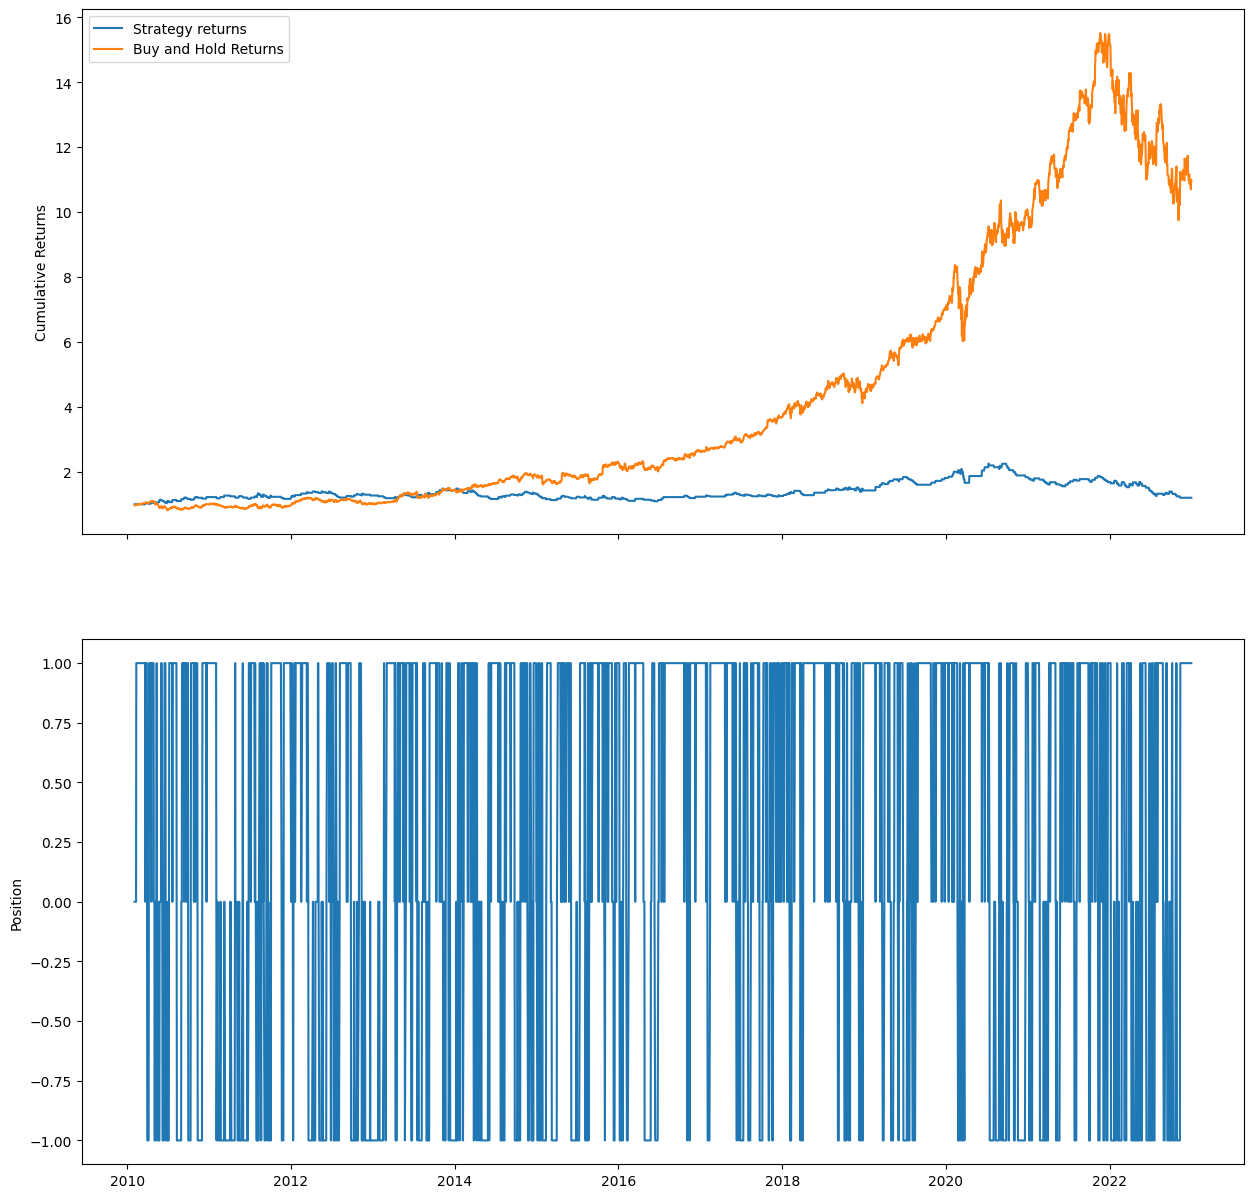

In [32]:
# compute the daily returns (buy-and-hold returns)
df['daily_ret'] = df['Close'].pct_change()

# Compute the strategy and buy-and-hold cumulative returns
df['strat_cum_ret'] = (1+df['trade_ret']).cumprod()
df['bh_cum_ret'] = (1+df['daily_ret']).cumprod()

# Plot returns
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
plt.subplot(211)
plt.plot(df.index,df[['strat_cum_ret', 'bh_cum_ret']],label=['Strategy returns', 'Buy and Hold Returns'])
plt.ylabel('Cumulative Returns')
plt.legend()

plt.subplot(212)
plt.plot(df.index,df['position'])
plt.ylabel('Position')

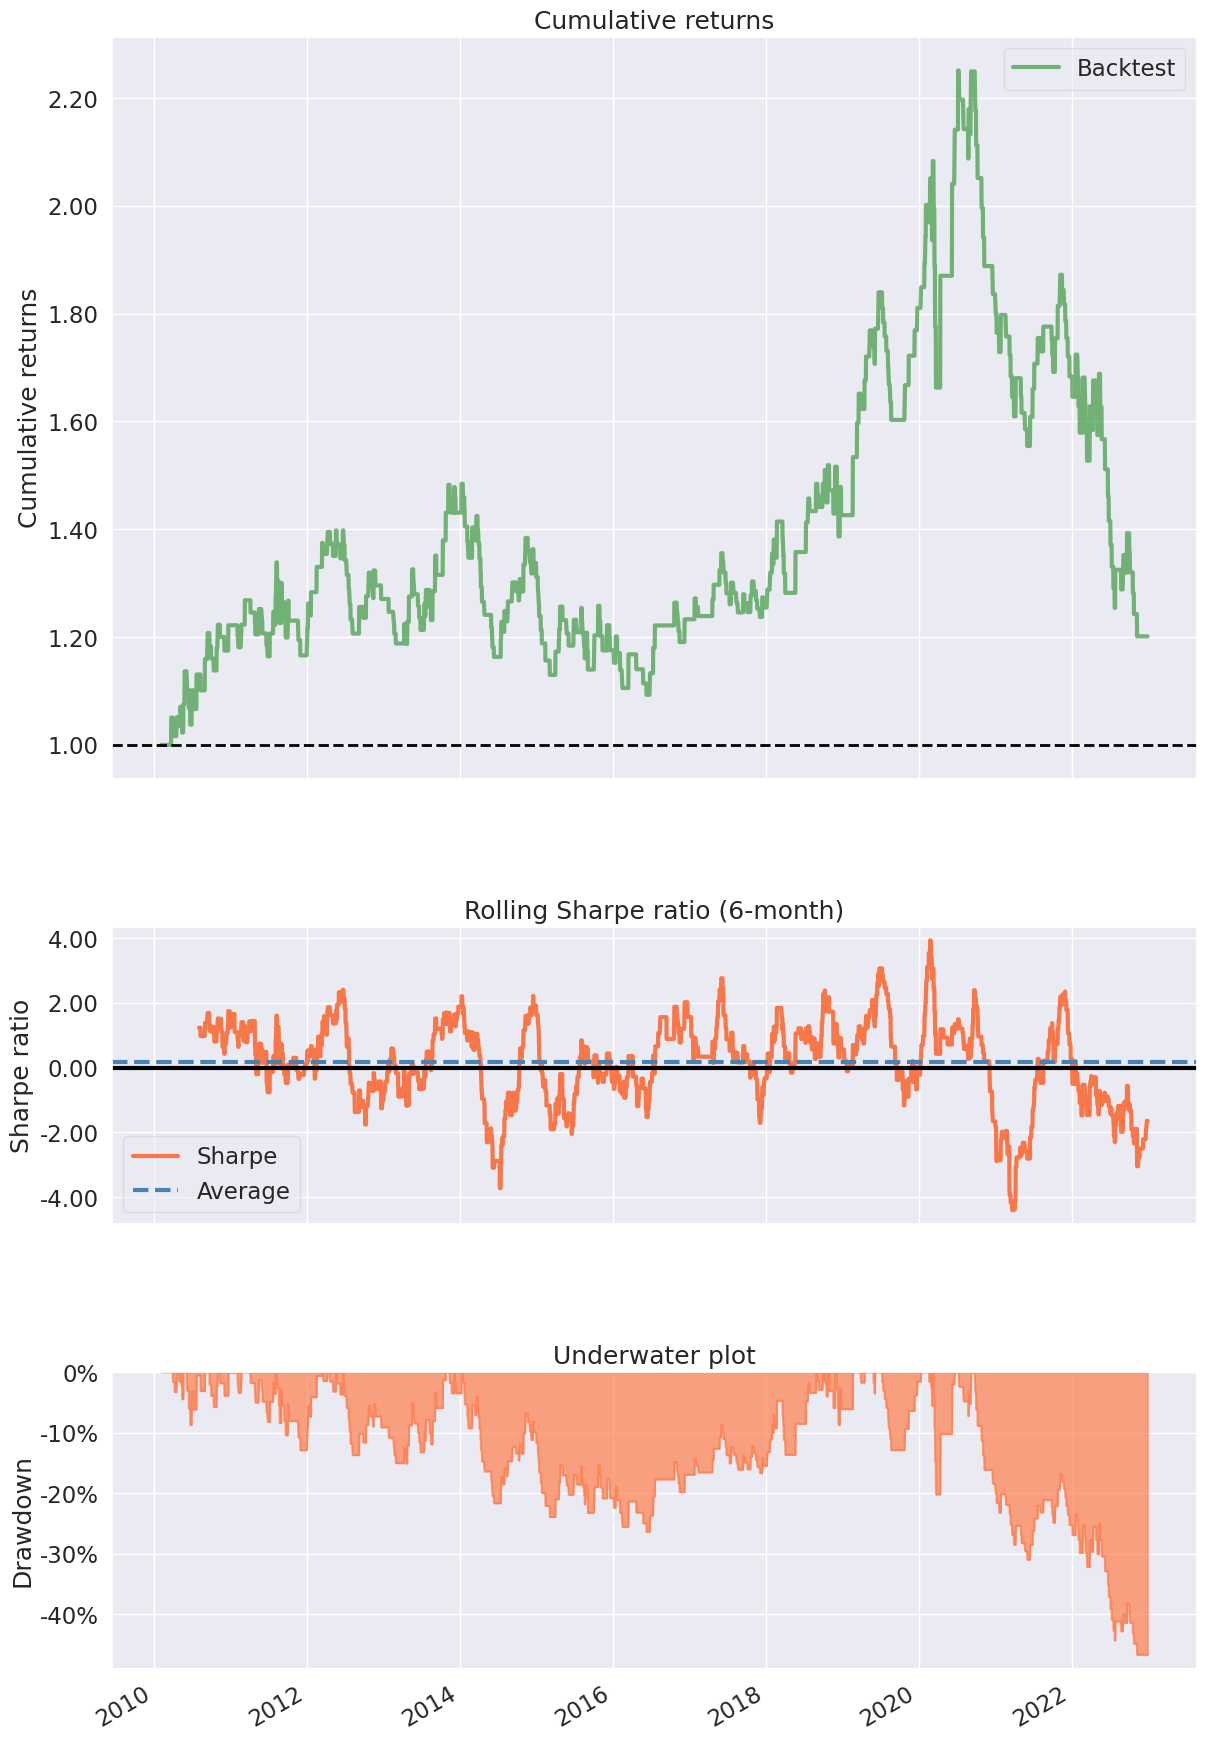

In [33]:
# Get the summary statistics for the strategy using pyfolio
pf.create_simple_tear_sheet(df['trade_ret'])

## Problem V - Backtest a strategy based on a high & low price

1. Go long when the stock closes above the last 20 day’s high price.
2. Square off the long position when the stock goes below the last 20 day’s low price.
3. Optional: Optimise the strategy by adjusting the number of periods. You can choose to have different number of periods for entering the long and exiting the long.

In [34]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
import pyfolio as pf

In [35]:
# setup
symbol = 'MSFT'
start = '2010-01-01'
end = '2022-12-31'
source = 'yahoo'
ndays_high = 20
ndays_low = 20
equity = 10000

# retrieving data from Yahoo
df = yf.download(symbol, start, end, group_by='ticker')[symbol]
df.tail(3)

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close    Volume
Date                                                                
2022-12-28  235.284558  238.095381  232.582991  232.940552  17457100
2022-12-29  234.052958  240.280469  234.052958  239.376633  19770700
2022-12-30  236.595628  238.333768  235.056129  238.194717  21938500

In [36]:
def backtest_strategy2(df, ndays_high=20,ndays_low=20):
    df = df.copy()
    df['signal'] = df['trade_price'] = df['trade_ret'] = 0.0
    
    # Compute the moving last n highest high
    df['ndays_high'] = df['High'].rolling(ndays_high).max().shift(1)
    df['ndays_low'] = df['Low'].rolling(ndays_low).min().shift(1)
    
    for i in range(1, len(df)):
    
        # Check if we have no position in the asset
        if df['signal'].iloc[i-1] == 0:
            # Check if we need to go long for today
            if df['Close'].iloc[i] > df['ndays_high'].iloc[i]:
                # We assign the signal to 1, i.e. we go long
                df['signal'].iloc[i] = 1
                # We assign to the trade price the close price
                df['trade_price'].iloc[i] = df['ndays_high'].iloc[i]
            # If there's no signal today, then do the following
            else:
                # We copy the yesterday's trade price on today's
                df['trade_price'].iloc[i] = df['Close'].iloc[i]  
        
        # Check if we have a long position in the previous day
        elif df['signal'].iloc[i-1] == 1:
            # Check if today we breached the square-off target
            if df['Close'].iloc[i] < df['ndays_low'].iloc[i]:
                # If it's true, then we assign today's signal as zero, i.e. square off the position
                df['signal'].iloc[i] = 0
                # We assign to the trade price the stop loss price
                df['trade_price'].iloc[i] = df['ndays_low'].iloc[i]
                # We compute the trade return for the day
                df['trade_ret'].iloc[i] = df['trade_price'].iloc[i] / df['trade_price'].iloc[i-1] - 1
            else:
                # If it's false, then we assign today's signal as the previous-day signal
                df['signal'].iloc[i] = df['signal'].iloc[i-1]
                # We assign to the trade price the previous-day trade price
                df['trade_price'].iloc[i] = df['trade_price'].iloc[i-1]

    return df


Text(0, 0.5, 'signal')

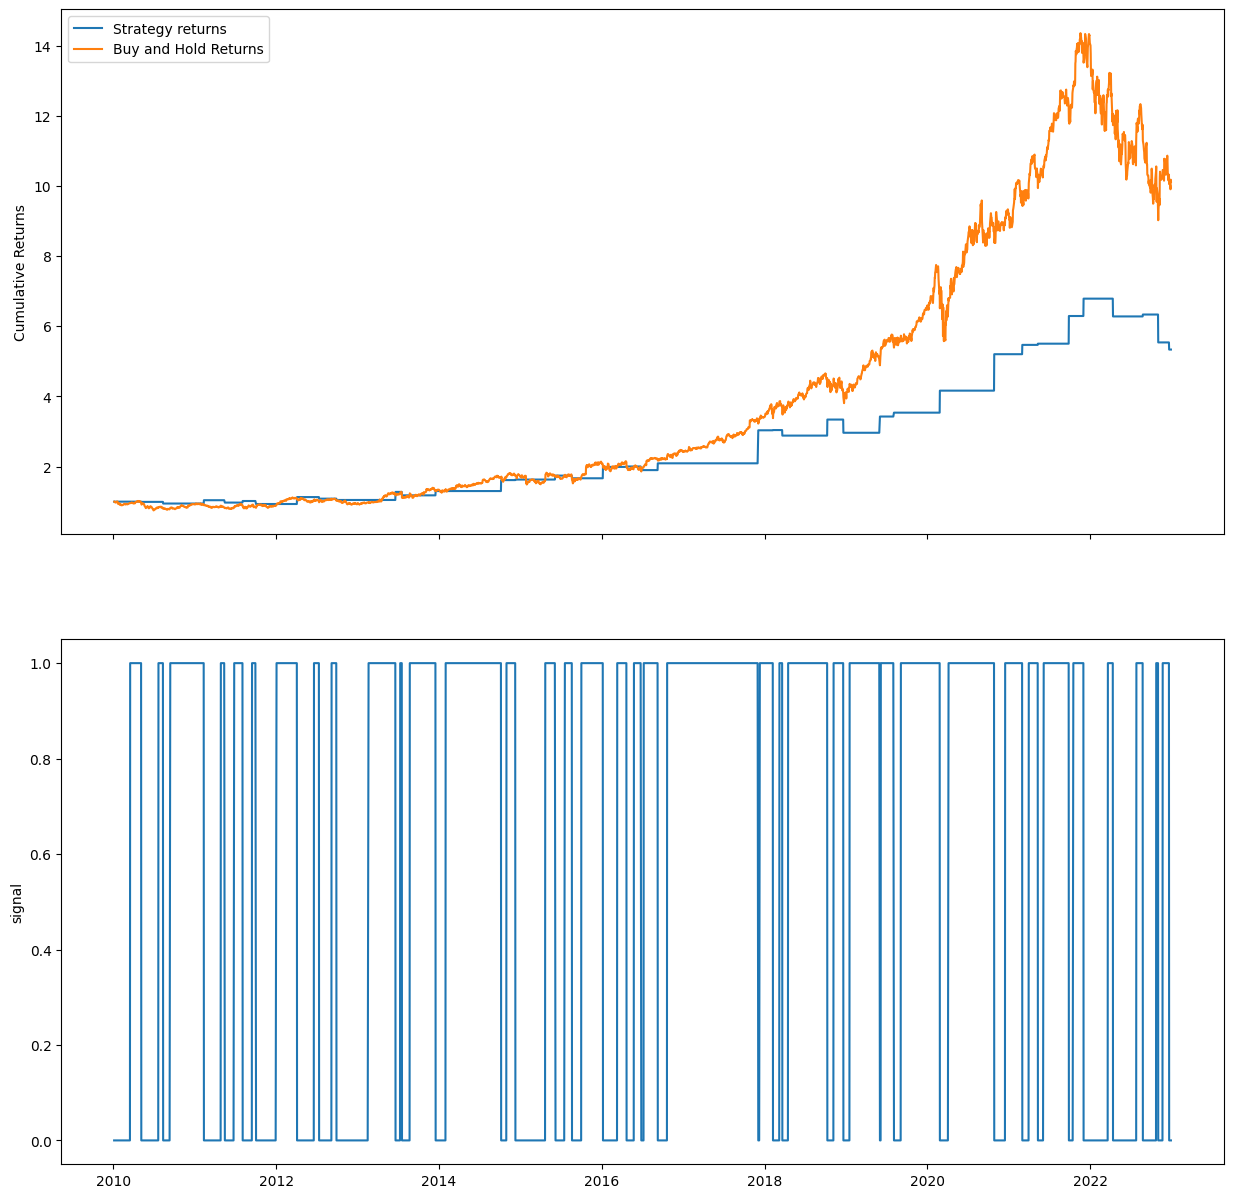

In [37]:
df2 = backtest_strategy2(df, ndays_high=20,ndays_low=20)

# compute the daily returns (buy-and-hold returns)
df2['daily_ret'] = df2['Close'].pct_change()

# Compute the strategy and buy-and-hold cumulative returns
df2['strat_cum_ret'] = (1+df2['trade_ret']).cumprod()
df2['bh_cum_ret'] = (1+df2['daily_ret']).cumprod()

# Plot returns
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
plt.subplot(211)
plt.plot(df2.index,df2[['strat_cum_ret', 'bh_cum_ret']],label=['Strategy returns', 'Buy and Hold Returns'])
plt.ylabel('Cumulative Returns')
plt.legend()

plt.subplot(212)
plt.plot(df2.index,df2['signal'])
plt.ylabel('signal')

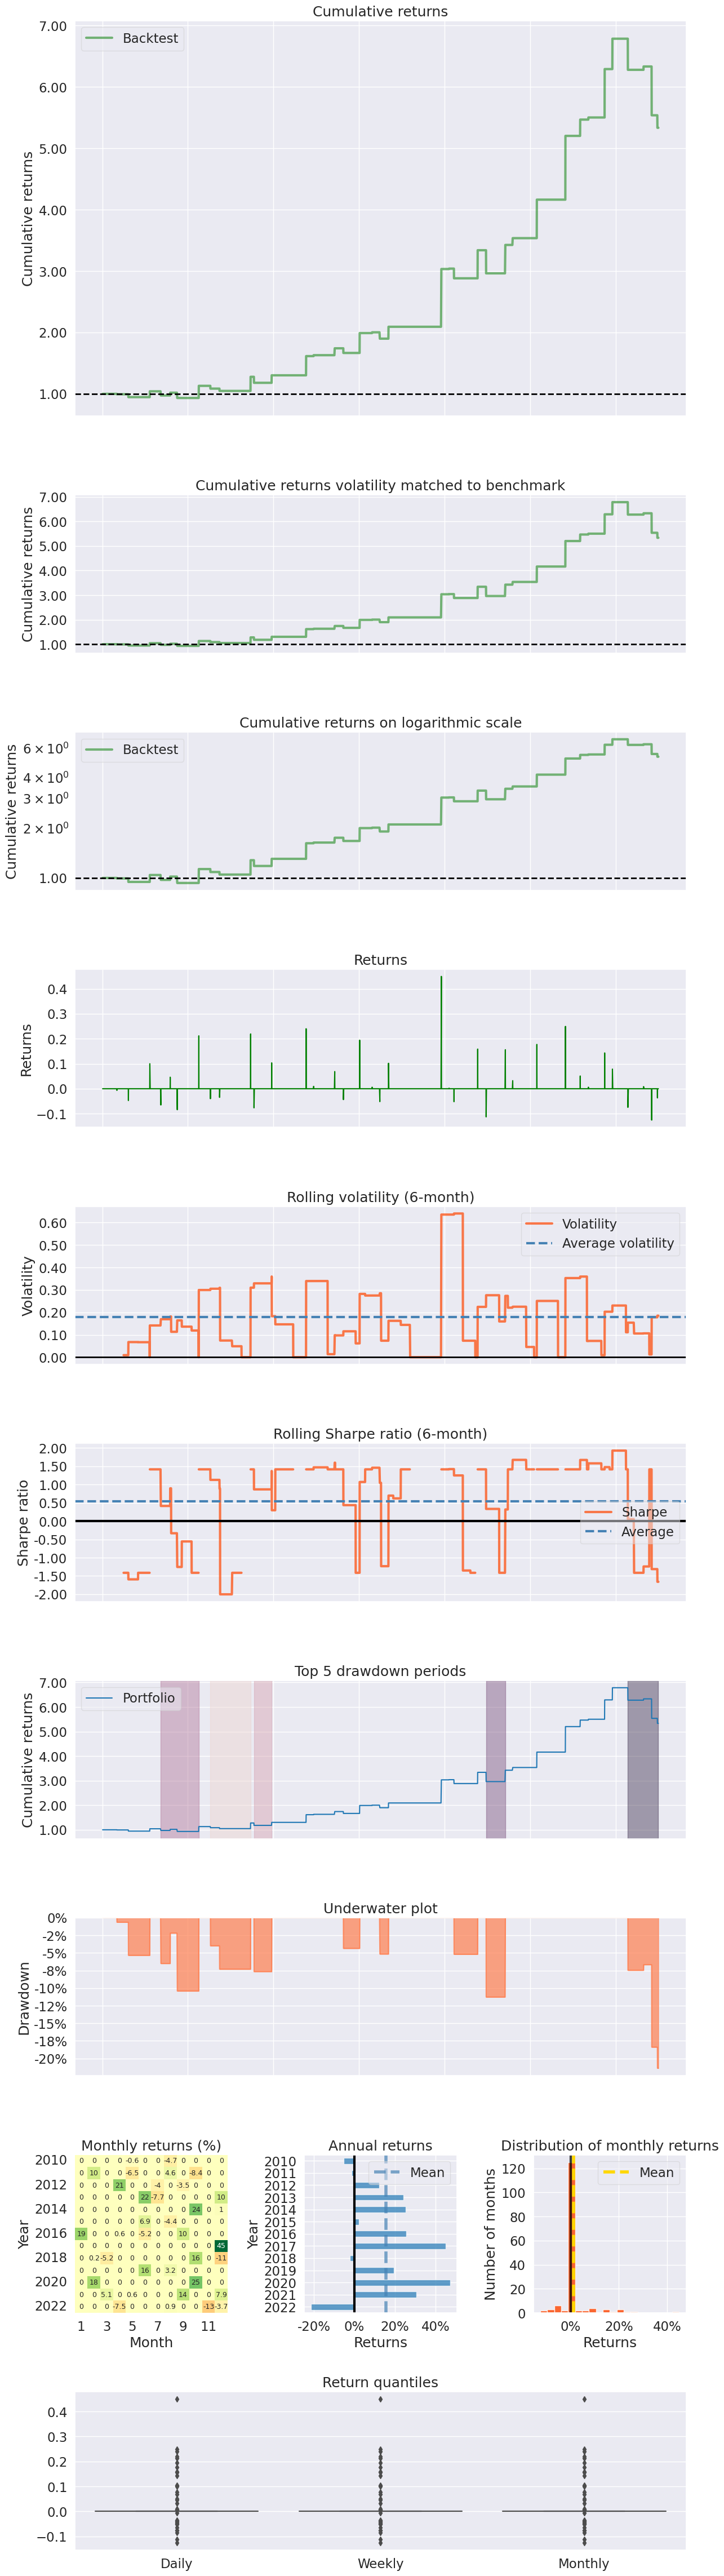

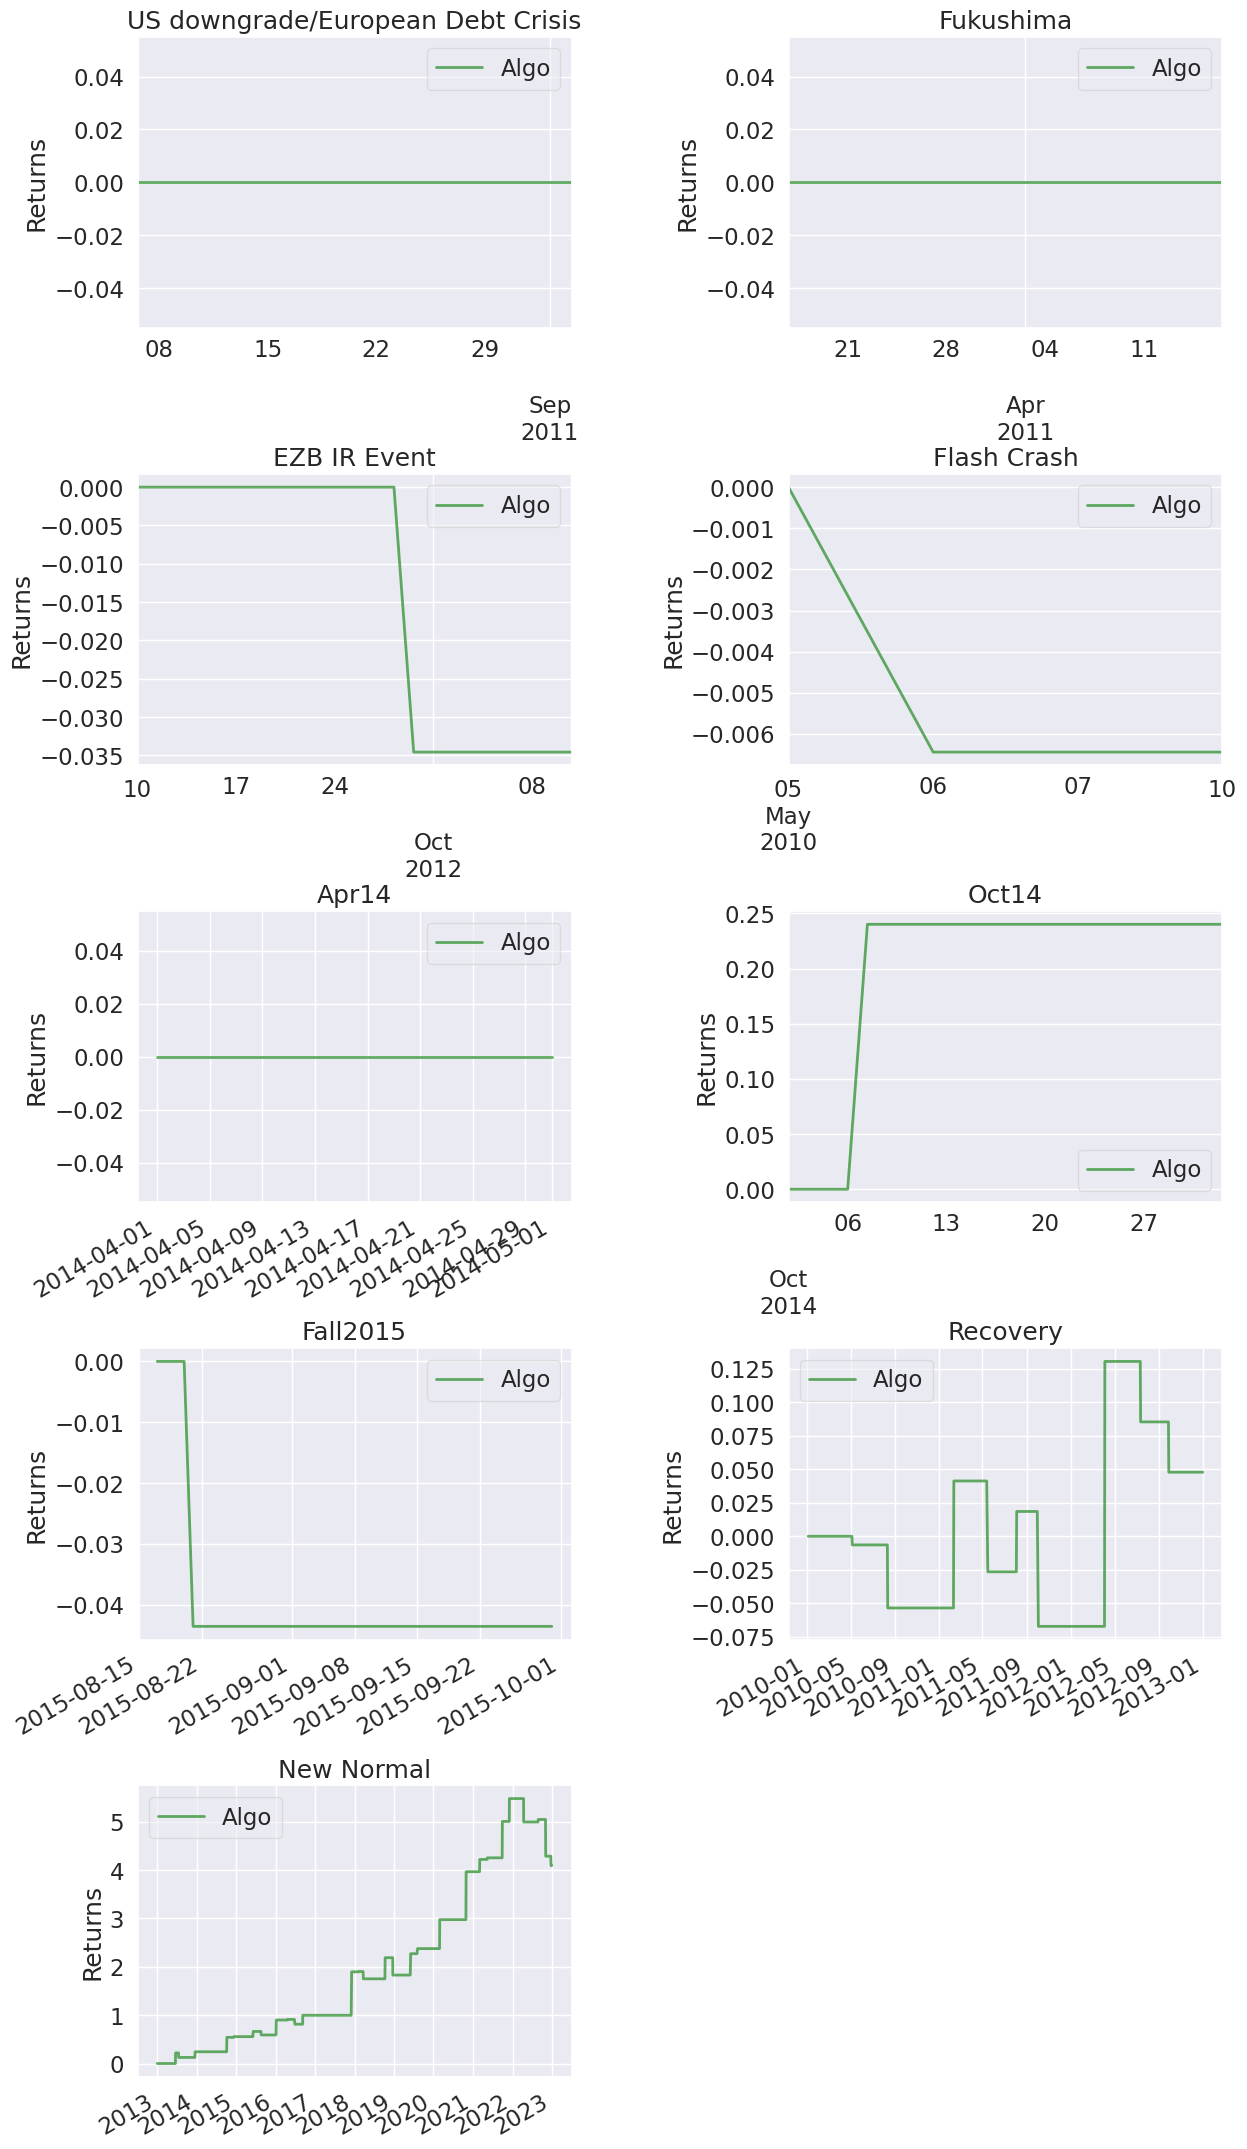

In [38]:
# Get the summary statistics for the strategy using pyfolio
pf.create_full_tear_sheet(df2['trade_ret'])

In [39]:
high_name = ''
low_name = ''
strategies_returns = {}
for high in range(5,201,10):
    for low in range(5,201,10):
        if high < 10:
            high_name = f'00{high}'
        elif (high>=10) and (high<100):
            high_name = f'0{high}'
        else:
            high_name = f'{high}'
        if low < 10:
            low_name = f'00{low}'
        elif (low>=10) and (low<100):
            low_name = f'0{low}'
        else:
            high_name = f'{low}'
    strategies_returns[f'h_l_{high_name}_{low_name}'] = \
        (1+backtest_strategy2(df, ndays_high=high,ndays_low=low)['trade_ret']).cumprod()[-1]

Best high and low window sizes are 195 and 95, respectively


Text(0, 0.5, 'signal')

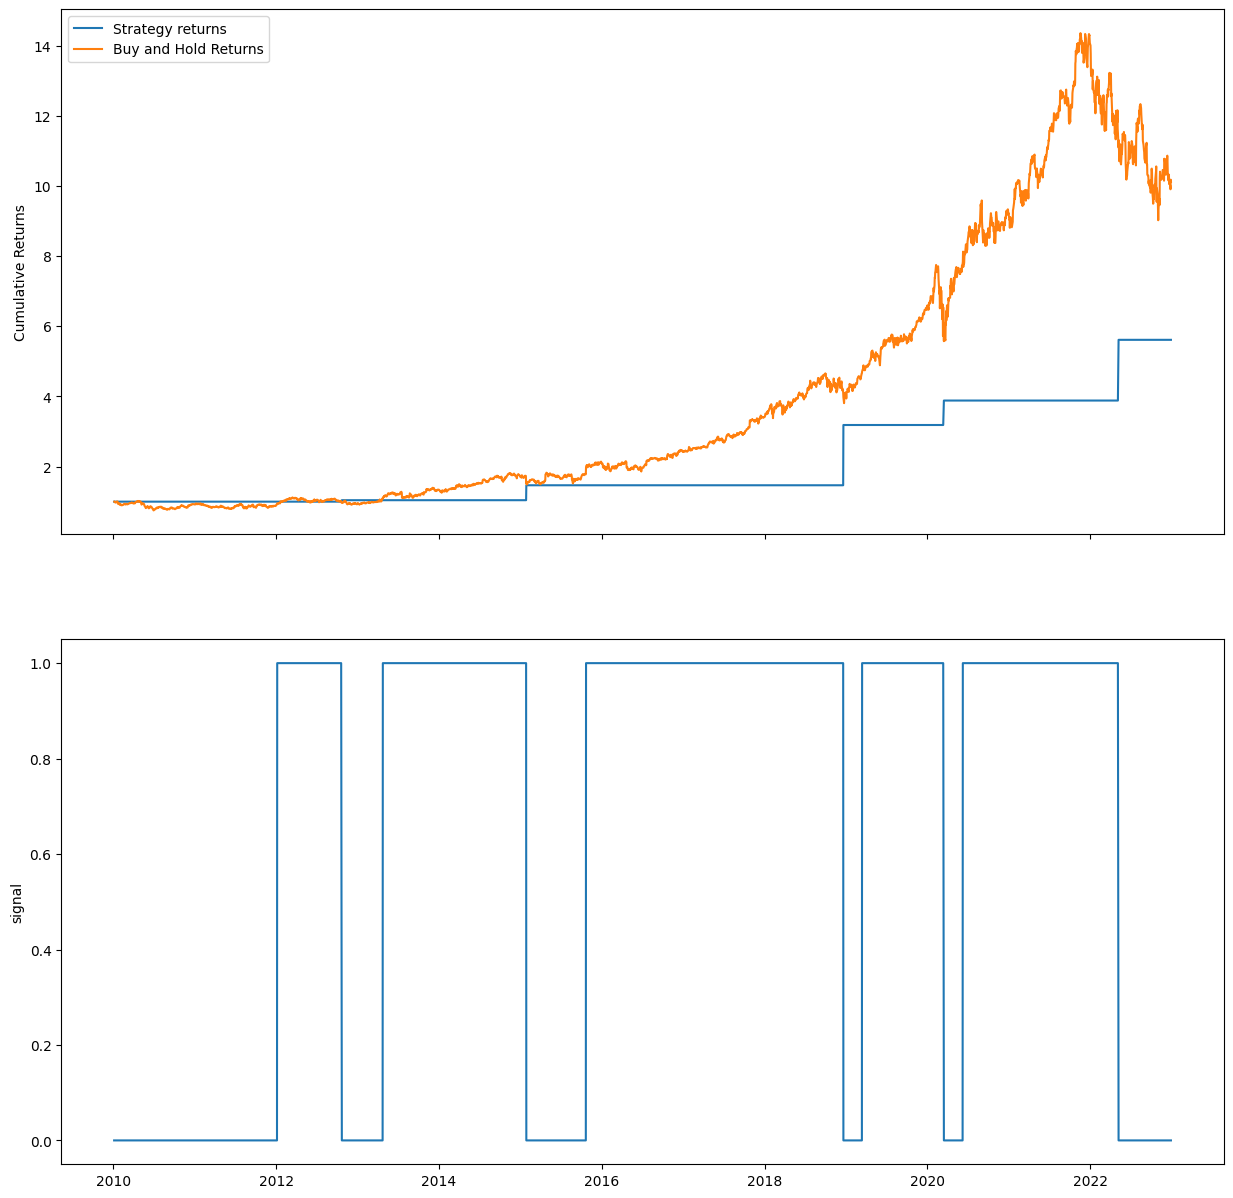

In [40]:
best_inputs = max(strategies_returns, key= lambda x: strategies_returns[x])

best_high = int(best_inputs[4:7])
best_low = int(best_inputs[8:])

df_opt = backtest_strategy2(df, ndays_high=best_high, ndays_low=best_low)

# compute the daily returns (buy-and-hold returns)
df_opt['daily_ret'] = df_opt['Close'].pct_change()

# Compute the strategy and buy-and-hold cumulative returns
df_opt['strat_cum_ret'] = (1+df_opt['trade_ret']).cumprod()
df_opt['bh_cum_ret'] = (1+df_opt['daily_ret']).cumprod()

print(f'Best high and low window sizes are {best_high} and {best_low}, respectively')

# Plot returns
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
plt.subplot(211)
plt.plot(df_opt.index,df_opt[['strat_cum_ret', 'bh_cum_ret']],label=['Strategy returns', 'Buy and Hold Returns'])
plt.ylabel('Cumulative Returns')
plt.legend()

plt.subplot(212)
plt.plot(df_opt.index,df_opt['signal'])
plt.ylabel('signal')